In [3]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import time
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [4]:
DATA_PATH = Path("Trips_2018.csv")

chunk_iter = pd.read_csv(DATA_PATH, chunksize=500000, low_memory=True)  # 0.5M rows per chunk

chunks = []
for i, chunk in enumerate(chunk_iter):
    print("Loaded chunk:", i, "→ rows:", len(chunk))
    chunks.append(chunk)

df = pd.concat(chunks, ignore_index=True)
print("Combined shape:", df.shape)

Loaded chunk: 0 → rows: 500000
Loaded chunk: 1 → rows: 500000
Loaded chunk: 2 → rows: 500000
Loaded chunk: 3 → rows: 500000
Loaded chunk: 4 → rows: 500000
Loaded chunk: 5 → rows: 500000
Loaded chunk: 6 → rows: 500000
Loaded chunk: 7 → rows: 500000
Loaded chunk: 8 → rows: 500000
Loaded chunk: 9 → rows: 500000
Loaded chunk: 10 → rows: 500000
Loaded chunk: 11 → rows: 500000
Loaded chunk: 12 → rows: 500000
Loaded chunk: 13 → rows: 500000
Loaded chunk: 14 → rows: 500000
Loaded chunk: 15 → rows: 500000
Loaded chunk: 16 → rows: 500000
Loaded chunk: 17 → rows: 500000
Loaded chunk: 18 → rows: 500000
Loaded chunk: 19 → rows: 500000
Loaded chunk: 20 → rows: 500000
Loaded chunk: 21 → rows: 500000
Loaded chunk: 22 → rows: 500000
Loaded chunk: 23 → rows: 500000
Loaded chunk: 24 → rows: 500000
Loaded chunk: 25 → rows: 500000
Loaded chunk: 26 → rows: 500000
Loaded chunk: 27 → rows: 500000
Loaded chunk: 28 → rows: 500000
Loaded chunk: 29 → rows: 500000
Loaded chunk: 30 → rows: 500000
Loaded chunk: 31 →

In [5]:
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

#Convert start and stop times to proper datetime format
df["starttime"] = pd.to_datetime(df["starttime"], errors="coerce")
df["stoptime"]  = pd.to_datetime(df.get("stoptime"), errors="coerce")


#Create a new column 'start_hour' — the trip’s start time rounded down to the hour (used later to join with hourly weather data)
df["start_hour"] = df["starttime"].dt.floor("h")

#Compute trip duration in minutes
df["trip_duration_min"] = (
    df["tripduration"]/60.0
    if "tripduration" in df.columns
    else (df["stoptime"] - df["starttime"]).dt.total_seconds()/60
)

#Find a representative latitude and longitude for weather data Using median coordinates ensures one central location (e.g., NYC center)
LAT, LON = df["start_station_latitude"].median(), df["start_station_longitude"].median()

#Find the overall date range of the dataset for API query
START = df["start_hour"].min().date().isoformat()
END   = df["start_hour"].max().date().isoformat()

#Print a quick summary
print(f"Trips: {len(df)}  |  Date span: {START} → {END}")
df.head()

Trips: 17548339  |  Date span: 2018-01-01 → 2018-12-31


tripduration               starttime                stoptime  \
0           970 2018-01-01 13:50:57.434 2018-01-01 14:07:08.186   
1           723 2018-01-01 15:33:30.182 2018-01-01 15:45:33.341   
2           496 2018-01-01 15:39:18.337 2018-01-01 15:47:35.172   
3           306 2018-01-01 15:40:13.372 2018-01-01 15:45:20.191   
4           306 2018-01-01 18:14:51.568 2018-01-01 18:19:57.642   

   start_station_id  start_station_latitude  start_station_longitude  \
0              72.0               40.767272               -73.993929   
1              72.0               40.767272               -73.993929   
2              72.0               40.767272               -73.993929   
3              72.0               40.767272               -73.993929   
4              72.0               40.767272               -73.993929   

   end_station_id  end_station_latitude  end_station_longitude  bikeid  \
0           505.0             40.749013             -73.988484   31956   
1          3255.0             40.750585             -73.994685   32536   
2           525.0             40.755942             -74.002116   16069   
3           447.0             40.763707             -73.985162   31781   
4          3356.0             40.774667             -73.984706   30319   

     usertype  birth_year  gender          start_hour  trip_duration_min  
0  Subscriber        1992       1 2018-01-01 13:00:00          16.166667  
1  Subscriber        1969       1 2018-01-01 15:00:00          12.050000  
2  Subscriber        1956       1 2018-01-01 15:00:00           8.266667  
3  Subscriber        1974       1 2018-01-01 15:00:00           5.100000  
4  Subscriber        1992       1 2018-01-01 18:00:00           5.100000

In [6]:
stations = df[["start_station_id", "start_station_latitude", "start_station_longitude"]].drop_duplicates()

# 1) Build a small grid (≈2–3 km) to reduce API calls
GRID = 0.03  # ↑ 0.05 fewer calls, ↓ 0.02 more detail

stations = stations.copy()
stations["lat_bin"] = (stations["start_station_latitude"]  / GRID).round().astype(int)
stations["lon_bin"] = (stations["start_station_longitude"] / GRID).round().astype(int)
stations["cell_id"] = stations["lat_bin"].astype(str) + "_" + stations["lon_bin"].astype(str)

cells = (stations.groupby("cell_id", as_index=False)
         .agg(lat=("start_station_latitude", "median"),
              lon=("start_station_longitude", "median")))

print(f"Unique grid cells to fetch: {len(cells)}")


# 2) Helper: polite, retrying fetch per cell
def fetch_cell(lat, lon, start_date, end_date, retries=5, pause=1.5):
    url = "https://archive-api.open-meteo.com/v1/era5"
    hourly_vars = [
        "temperature_2m","apparent_temperature","rain","snowfall",
        "wind_speed_10m","relative_humidity_2m","cloud_cover","visibility"
    ]
    params = {
        "latitude": float(lat), "longitude": float(lon),
        "start_date": start_date, "end_date": end_date,
        "timezone": "America/New_York",
        "hourly": ",".join(hourly_vars)  # more robust than list for some clients
    }
    last_err = None
    for a in range(retries):
        try:
            resp = requests.get(url, params=params, timeout=40)
            if resp.ok:
                js = resp.json()
                if "hourly" in js:
                    wx = pd.DataFrame(js["hourly"])
                    wx["start_hour"] = pd.to_datetime(wx["time"])
                    wx = wx.drop(columns=["time"])
                    # downcast floats to save memory
                    for c in wx.columns:
                        if c != "start_hour" and pd.api.types.is_float_dtype(wx[c]):
                            wx[c] = pd.to_numeric(wx[c], downcast="float")
                    return wx
                else:
                    last_err = f"no 'hourly' in response (keys={list(js.keys())})"
            else:
                last_err = f"HTTP {resp.status_code}: {resp.text[:160]}"
        except Exception as e:
            last_err = str(e)
        time.sleep(pause * (a + 1))  # gentle backoff
    # Uncomment for debugging:
    # print(f"Fetch failed for ({lat:.4f},{lon:.4f}): {last_err}")
    return None


# 3) Fetch once per cell
cell_weather, failed_cells = [], []
for _, r in cells.iterrows():
    wx_cell = fetch_cell(r["lat"], r["lon"], START, END)
    if wx_cell is None:
        failed_cells.append(r["cell_id"])
        continue
    wx_cell["cell_id"] = r["cell_id"]
    cell_weather.append(wx_cell)
    time.sleep(0.2)  # pacing

# --- Fallback if everything failed: use single (city-median) point ---
if not cell_weather:
    print(" All grid cells failed. Falling back to city-median weather…")
    lat0 = float(df["start_station_latitude"].median())
    lon0 = float(df["start_station_longitude"].median())
    wx_city = fetch_cell(lat0, lon0, START, END)
    if wx_city is None:
        raise RuntimeError(
            f"No weather fetched even for city median. Check network/date range. START={START}, END={END}"
        )
    wx_city["cell_id"] = "city_median"
    wx_cells = wx_city.copy()
    stations2 = stations.copy()
    stations2["use_cell"] = "city_median"
else:
    wx_cells = pd.concat(cell_weather, ignore_index=True)
    print(f"Weather rows (cells): {len(wx_cells)} | cells covered: {wx_cells['cell_id'].nunique()}")

    # 4) If some cells failed, borrow weather from nearest fetched cell
    if failed_cells:
        print("Filling missing cells from nearest fetched cell…")

        have = cells[cells["cell_id"].isin(wx_cells["cell_id"].unique())].copy()
        need = cells[cells["cell_id"].isin(failed_cells)].copy()

        def haversine(lat1, lon1, lat2, lon2):
            R = 6371.0
            lat1, lon1, lat2, lon2 = map(np.radians, (lat1, lon1, lat2, lon2))
            dlat, dlon = lat2 - lat1, lon2 - lon1
            a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
            return 2 * R * np.arcsin(np.sqrt(a))

        alias_rows = []
        H_lat = have["lat"].to_numpy()
        H_lon = have["lon"].to_numpy()
        for _, r in need.iterrows():
            d = haversine(r["lat"], r["lon"], H_lat, H_lon)
            nearest = have.iloc[d.argmin()]["cell_id"]
            alias_rows.append((r["cell_id"], nearest))
        alias = pd.DataFrame(alias_rows, columns=["cell_id", "use_cell"])
    else:
        alias = pd.DataFrame(columns=["cell_id", "use_cell"])

    # Stations use their own cell if fetched, otherwise the nearest fetched cell
    stations2 = stations.merge(alias, on="cell_id", how="left")
    stations2["use_cell"] = stations2["use_cell"].fillna(stations2["cell_id"])

# 5) Expand cell weather back to stations
wx = (stations2[["start_station_id", "use_cell"]]
      .rename(columns={"use_cell": "cell_id"})
      .merge(wx_cells, on="cell_id", how="left"))

print("Total weather rows (expanded to stations):", len(wx))

Unique grid cells to fetch: 26
Weather rows (cells): 227760 | cells covered: 26
Total weather rows (expanded to stations): 8050440


In [7]:
is_station_level = "start_station_id" in wx.columns

if is_station_level:
    df["start_station_id"] = pd.array(df["start_station_id"], dtype="Int32")
    wx["start_station_id"] = pd.array(wx["start_station_id"], dtype="Int32")

key_cols = ["start_hour"] + (["start_station_id"] if is_station_level else [])

print("Merging on:", key_cols)

# keep only weather fields we actually need (saves memory) if present
wanted_wx = [
    "start_hour", "start_station_id",
    "temperature_2m","apparent_temperature","rain","snowfall",
    "wind_speed_10m","relative_humidity_2m","cloud_cover","visibility"
]

wx_subset = wx.filter(items=[c for c in wanted_wx if c in wx.columns], axis=1)
if is_station_level and "start_station_id" in wx_subset.columns:
    wx_subset["start_station_id"] = pd.array(wx_subset["start_station_id"], dtype="Int32")

wx_keyed = wx_subset.drop_duplicates(subset=key_cols)

dfm = df.merge(
    wx_keyed,
    on=key_cols,
    how="left",          # keep all trips/columns from df
    validate="m:1",      # many trips to one weather row
    copy=False
)

# merge quality
total_rows = len(dfm)
valid_weather = dfm["temperature_2m"].count()
coverage_pct = (valid_weather / total_rows * 100) if total_rows else 0.0
print(f"Merge complete | rows={total_rows:,} | weather coverage={coverage_pct:.1f}%")

dfm.head()

Merging on: ['start_hour', 'start_station_id']
Merge complete | rows=17,548,339 | weather coverage=100.0%


tripduration               starttime                stoptime  \
0           970 2018-01-01 13:50:57.434 2018-01-01 14:07:08.186   
1           723 2018-01-01 15:33:30.182 2018-01-01 15:45:33.341   
2           496 2018-01-01 15:39:18.337 2018-01-01 15:47:35.172   
3           306 2018-01-01 15:40:13.372 2018-01-01 15:45:20.191   
4           306 2018-01-01 18:14:51.568 2018-01-01 18:19:57.642   

   start_station_id  start_station_latitude  start_station_longitude  \
0                72               40.767272               -73.993929   
1                72               40.767272               -73.993929   
2                72               40.767272               -73.993929   
3                72               40.767272               -73.993929   
4                72               40.767272               -73.993929   

   end_station_id  end_station_latitude  end_station_longitude  bikeid  ...  \
0           505.0             40.749013             -73.988484   31956  ...   
1          3255.0             40.750585             -73.994685   32536  ...   
2           525.0             40.755942             -74.002116   16069  ...   
3           447.0             40.763707             -73.985162   31781  ...   
4          3356.0             40.774667             -73.984706   30319  ...   

           start_hour  trip_duration_min  temperature_2m apparent_temperature  \
0 2018-01-01 13:00:00          16.166667            -8.1                -14.9   
1 2018-01-01 15:00:00          12.050000            -6.9                -13.7   
2 2018-01-01 15:00:00           8.266667            -6.9                -13.7   
3 2018-01-01 15:00:00           5.100000            -6.9                -13.7   
4 2018-01-01 18:00:00           5.100000           -10.0                -15.0   

   rain  snowfall  wind_speed_10m  relative_humidity_2m  cloud_cover  \
0   0.0       0.0       20.400000                    30            0   
1   0.0       0.0       19.700001                    24           55   
2   0.0       0.0       19.700001                    24           55   
3   0.0       0.0       19.700001                    24           55   
4   0.0       0.0        7.400000                    39           23   

   visibility  
0        None  
1        None  
2        None  
3        None  
4        None  

[5 rows x 23 columns]

In [8]:
#Feature engineering: concise, robust, memory-friendly ===

need = ["temperature_2m","rain","snowfall","wind_speed_10m","cloud_cover","visibility"]
for c in need:
    if c not in dfm.columns:
        dfm[c] = np.nan
dfm[need] = dfm[need].apply(pd.to_numeric, errors="coerce")

# 1) Temperature (°C) + readable buckets
dfm["temp_celsius"] = dfm["temperature_2m"]
dfm["temp_category"] = pd.cut(
    dfm["temp_celsius"],
    bins=[-99, 0, 10, 20, 25, 30, 99],
    labels=["freezing","cold","cool","comfortable","warm","hot"]
)

# 2) Dryness (1 dry, 0 wet)
rain  = dfm["rain"].fillna(0)
snow  = dfm["snowfall"].fillna(0)
dfm["is_dry"] = ((rain + snow) == 0).astype("int8")

# 3) Wind, sky, visibility
dfm["wind_kmh"] = dfm["wind_speed_10m"] * 3.6
dfm["sky_condition"] = pd.cut(
    dfm["cloud_cover"],
    bins=[-1, 25, 50, 75, 100.1],
    labels=["clear","partly_cloudy","cloudy","overcast"]
)
dfm["visibility_km"] = dfm["visibility"] / 1000.0

# 4) Cycling Score (0–100): temp comfort 40% + dryness 30% + low wind 20% + visibility 10%
dfm["cycling_score"] = (
    np.exp(-((dfm["temp_celsius"] - 20) / 10) ** 2) * 40           # temperature comfort peak ~20°C
    + dfm["is_dry"] * 30                                           # dry bonus
    + (dfm["wind_kmh"] < 20).astype("int8") * 20                   # calm wind
    + (dfm["visibility_km"] > 5).astype("int8") * 10               # clear view
).clip(0, 100)

# 5) Compact memory for categories
dfm["temp_category"] = dfm["temp_category"].astype("category")
dfm["sky_condition"]  = dfm["sky_condition"].astype("category")

print(f"Weather features added | shape={dfm.shape} | new cols: "
      f"['temp_celsius','temp_category','is_dry','wind_kmh','sky_condition','visibility_km','cycling_score']")
dfm.head()

Weather features added | shape=(17548339, 30) | new cols: ['temp_celsius','temp_category','is_dry','wind_kmh','sky_condition','visibility_km','cycling_score']


tripduration               starttime                stoptime  \
0           970 2018-01-01 13:50:57.434 2018-01-01 14:07:08.186   
1           723 2018-01-01 15:33:30.182 2018-01-01 15:45:33.341   
2           496 2018-01-01 15:39:18.337 2018-01-01 15:47:35.172   
3           306 2018-01-01 15:40:13.372 2018-01-01 15:45:20.191   
4           306 2018-01-01 18:14:51.568 2018-01-01 18:19:57.642   

   start_station_id  start_station_latitude  start_station_longitude  \
0                72               40.767272               -73.993929   
1                72               40.767272               -73.993929   
2                72               40.767272               -73.993929   
3                72               40.767272               -73.993929   
4                72               40.767272               -73.993929   

   end_station_id  end_station_latitude  end_station_longitude  bikeid  ...  \
0           505.0             40.749013             -73.988484   31956  ...   
1          3255.0             40.750585             -73.994685   32536  ...   
2           525.0             40.755942             -74.002116   16069  ...   
3           447.0             40.763707             -73.985162   31781  ...   
4          3356.0             40.774667             -73.984706   30319  ...   

  relative_humidity_2m  cloud_cover  visibility temp_celsius  temp_category  \
0                   30            0         NaN         -8.1       freezing   
1                   24           55         NaN         -6.9       freezing   
2                   24           55         NaN         -6.9       freezing   
3                   24           55         NaN         -6.9       freezing   
4                   39           23         NaN        -10.0       freezing   

   is_dry   wind_kmh  sky_condition  visibility_km  cycling_score  
0       1  73.439995          clear            NaN      30.014887  
1       1  70.919998         cloudy            NaN      30.028805  
2       1  70.919998         cloudy            NaN      30.028805  
3       1  70.919998         cloudy            NaN      30.028805  
4       1  26.639999          clear            NaN      30.004936  

[5 rows x 30 columns]

In [9]:
# Add temporal columns needed for analysis
dfm['day_of_week'] = dfm['starttime'].dt.dayofweek
dfm['is_weekend'] = (dfm['day_of_week'] >= 5).astype(int)
dfm['hour'] = dfm['start_hour'].dt.hour
dfm['month'] = dfm['starttime'].dt.month

print(f"Dataset ready: {len(dfm):,} trips with weather and temporal features")

Dataset ready: 17,548,339 trips with weather and temporal features


In [10]:
hourly_demand = (
    dfm.groupby("start_hour", observed=True)
       .size()
       .rename("trip_count")
       .reset_index()
       .sort_values("start_hour")
       .reset_index(drop=True)
)

hourly_demand.head()

start_hour  trip_count
0 2018-01-01 00:00:00         119
1 2018-01-01 01:00:00         168
2 2018-01-01 02:00:00          98
3 2018-01-01 03:00:00          72
4 2018-01-01 04:00:00          34

In [11]:
pickups = (
    df.groupby(['start_station_id', 'start_hour'])
      .size()
      .reset_index(name='pickups')
      .rename(columns={'start_station_id': 'station_id', 'start_hour': 'hour'})
)
dropoffs = (
    df.groupby(['end_station_id', 'start_hour'])
      .size()
      .reset_index(name='dropoffs')
      .rename(columns={'end_station_id': 'station_id', 'start_hour': 'hour'})
)

hourly_demand1= pd.merge(pickups, dropoffs, on=['station_id', 'hour'], how='outer').fillna(0)

hourly_demand1['pickups']= hourly_demand1['pickups'].astype(int)
hourly_demand1['dropoffs']= hourly_demand1['dropoffs'].astype(int)

min_hour = hourly_demand1['hour'].min()
max_hour = hourly_demand1['hour'].max() 
all_hours = pd.date_range(min_hour, max_hour, freq='h')

stations = hourly_demand1['station_id'].unique()
index = pd.MultiIndex.from_product([stations, all_hours], names=['station_id', 'hour'])

hourly_demand1 = hourly_demand1.set_index(['station_id', 'hour']).reindex(index, fill_value=0).reset_index() 
hourly_demand1.head(90)

station_id                hour  pickups  dropoffs
0         72.0 2018-01-01 00:00:00        0         0
1         72.0 2018-01-01 01:00:00        0         0
2         72.0 2018-01-01 02:00:00        0         0
3         72.0 2018-01-01 03:00:00        0         0
4         72.0 2018-01-01 04:00:00        0         0
..         ...                 ...      ...       ...
85        72.0 2018-01-04 13:00:00        0         0
86        72.0 2018-01-04 14:00:00        0         0
87        72.0 2018-01-04 15:00:00        1         0
88        72.0 2018-01-04 16:00:00        0         0
89        72.0 2018-01-04 17:00:00        0         0

[90 rows x 4 columns]

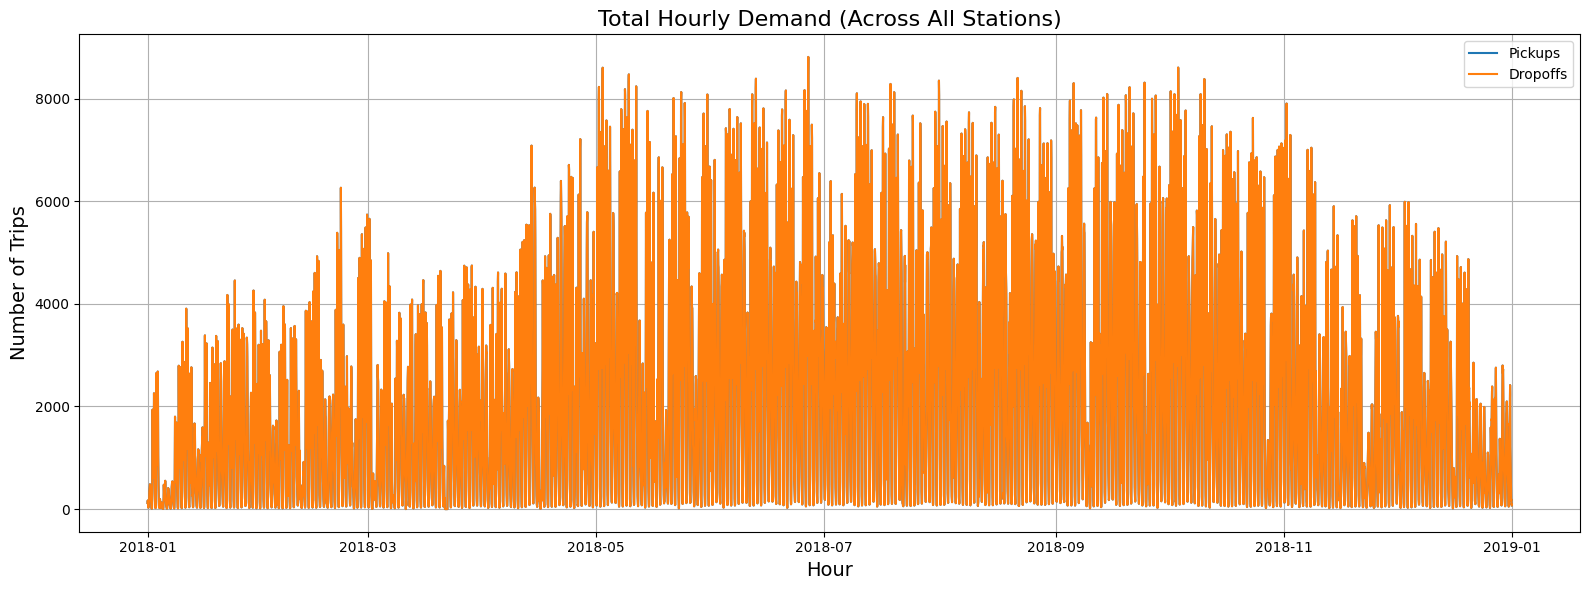

In [12]:
total_hourly = hourly_demand1.groupby("hour")[["pickups", "dropoffs"]].sum()

plt.figure(figsize=(16,6))
plt.plot(total_hourly.index, total_hourly["pickups"], label="Pickups")
plt.plot(total_hourly.index, total_hourly["dropoffs"], label="Dropoffs")

plt.title("Total Hourly Demand (Across All Stations)", fontsize=16)
plt.xlabel("Hour", fontsize=14)
plt.ylabel("Number of Trips", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


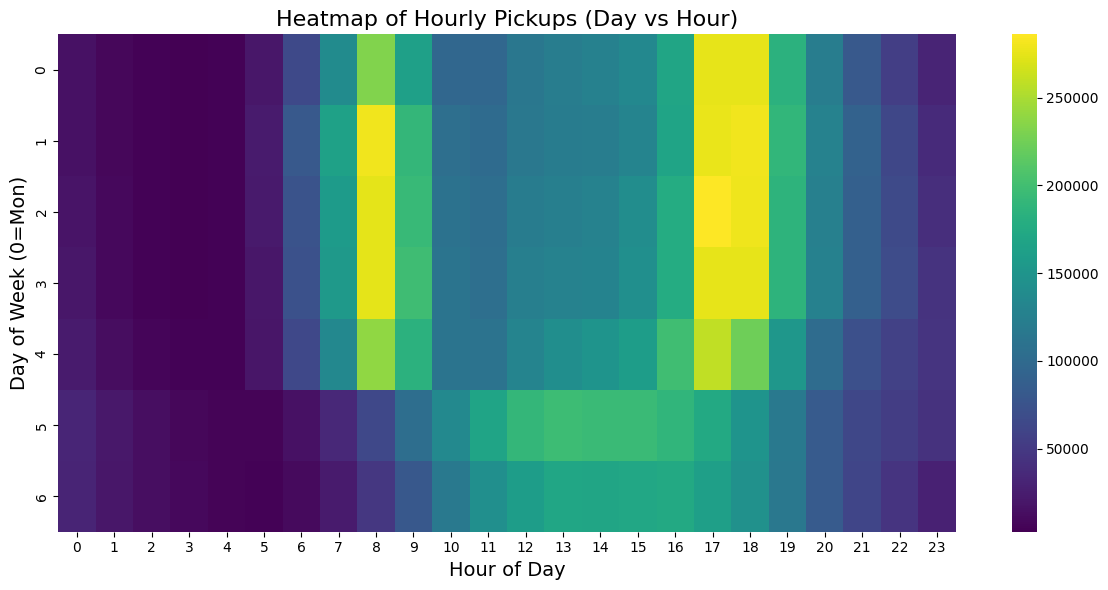

In [13]:
# Create hour-of-day & day-of-week fields
hourly_demand1['hour_of_day'] = hourly_demand1['hour'].dt.hour
hourly_demand1['day_of_week'] = hourly_demand1['hour'].dt.dayofweek  # 0=Monday

# Aggregate pickups by hour & day of week
heatmap_df = hourly_demand1.groupby(["day_of_week", "hour_of_day"])["pickups"].sum().unstack()
plt.figure(figsize=(12,6))
sns.heatmap(heatmap_df, cmap="viridis")

plt.title("Heatmap of Hourly Pickups (Day vs Hour)", fontsize=16)
plt.xlabel("Hour of Day", fontsize=14)
plt.ylabel("Day of Week (0=Mon)", fontsize=14)
plt.tight_layout()
plt.show()


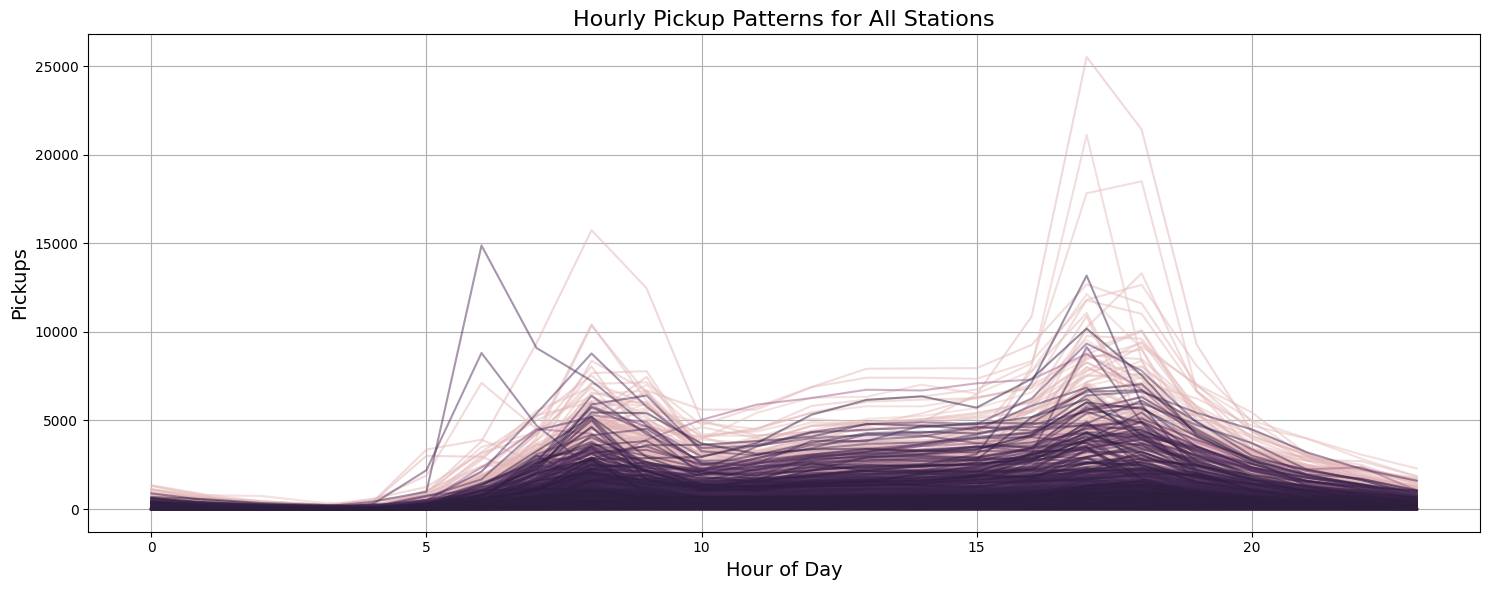

In [14]:
# Average hourly demand per station
station_hour = hourly_demand1.groupby(["station_id", "hour_of_day"])["pickups"].sum().reset_index()

plt.figure(figsize=(15,6))
sns.lineplot(data=station_hour, x="hour_of_day", y="pickups", hue="station_id", legend=False, alpha=0.5)

plt.title("Hourly Pickup Patterns for All Stations", fontsize=16)
plt.xlabel("Hour of Day", fontsize=14)
plt.ylabel("Pickups", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


Number of unique stations: 850


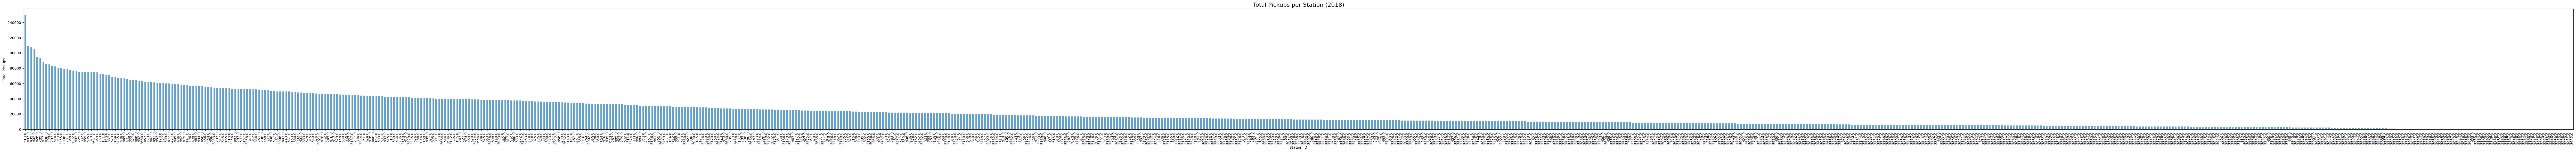

In [15]:
unique_stations = hourly_demand1['station_id'].nunique()
print(f"Number of unique stations: {unique_stations}")

station_totals = (
    hourly_demand1.groupby("station_id")["pickups"]
    .sum()
    .sort_values(ascending=False)
)

plt.figure(figsize=(100,6))
station_totals.plot(kind='bar', alpha=0.7)

plt.title("Total Pickups per Station (2018)", fontsize=16)
plt.xlabel("Station ID")
plt.ylabel("Total Pickups")
plt.tight_layout()
plt.show()


# Clustering

In [16]:
start_meta = df.groupby("start_station_id")[
    ["start_station_latitude", "start_station_longitude"]
].mean().reset_index().rename(columns={
    "start_station_id": "station_id",
    "start_station_latitude": "lat",
    "start_station_longitude": "lon"
})

end_meta = df.groupby("end_station_id")[
    ["end_station_latitude", "end_station_longitude"]
].mean().reset_index().rename(columns={
    "end_station_id": "station_id",
    "end_station_latitude": "lat",
    "end_station_longitude": "lon"
})

# Combine both tables
stations_meta = pd.concat([start_meta, end_meta], ignore_index=True)

# If the same station appears in both start & end tables, take average again
stations_meta = stations_meta.groupby("station_id")[["lat", "lon"]].mean().reset_index()

print("Number of unique stations:", len(stations_meta))
stations_meta.head()

Number of unique stations: 850


station_id        lat        lon
0        72.0  40.767272 -73.993929
1        79.0  40.719116 -74.006667
2        82.0  40.711174 -74.000165
3        83.0  40.683826 -73.976323
4       119.0  40.696089 -73.978034

In [17]:
stations_meta = stations_meta[
    (stations_meta['lat'] > 40.4) &
    (stations_meta['lat'] < 41) &
    (stations_meta['lon'] > -74.1) &
    (stations_meta['lon'] < -73.7)
]

N_CLUSTERS = 25   # you can choose any number >= 20

kmeans = KMeans(
    n_clusters=N_CLUSTERS,
    random_state=42,
    n_init='auto'
)

stations_meta["cluster"] = kmeans.fit_predict(stations_meta[["lat", "lon"]])

stations_meta.head()

station_id        lat        lon  cluster
0        72.0  40.767272 -73.993929        1
1        79.0  40.719116 -74.006667       22
2        82.0  40.711174 -74.000165       14
3        83.0  40.683826 -73.976323       20
4       119.0  40.696089 -73.978034       20

In [18]:
# Merge clusters back into hourly_demand
hourly_demand1 = hourly_demand1.merge(
    stations_meta[["station_id", "cluster"]],
    on="station_id",
    how="left"
)
hourly_demand1

station_id                hour  pickups  dropoffs  hour_of_day  \
0              72.0 2018-01-01 00:00:00        0         0            0   
1              72.0 2018-01-01 01:00:00        0         0            1   
2              72.0 2018-01-01 02:00:00        0         0            2   
3              72.0 2018-01-01 03:00:00        0         0            3   
4              72.0 2018-01-01 04:00:00        0         0            4   
...             ...                 ...      ...       ...          ...   
7445995      3721.0 2018-12-31 19:00:00        0         0           19   
7445996      3721.0 2018-12-31 20:00:00        0         0           20   
7445997      3721.0 2018-12-31 21:00:00        0         0           21   
7445998      3721.0 2018-12-31 22:00:00        0         0           22   
7445999      3721.0 2018-12-31 23:00:00        0         0           23   

         day_of_week  cluster  
0                  0      1.0  
1                  0      1.0  
2                  0      1.0  
3                  0      1.0  
4                  0      1.0  
...              ...      ...  
7445995            0      7.0  
7445996            0      7.0  
7445997            0      7.0  
7445998            0      7.0  
7445999            0      7.0  

[7446000 rows x 7 columns]

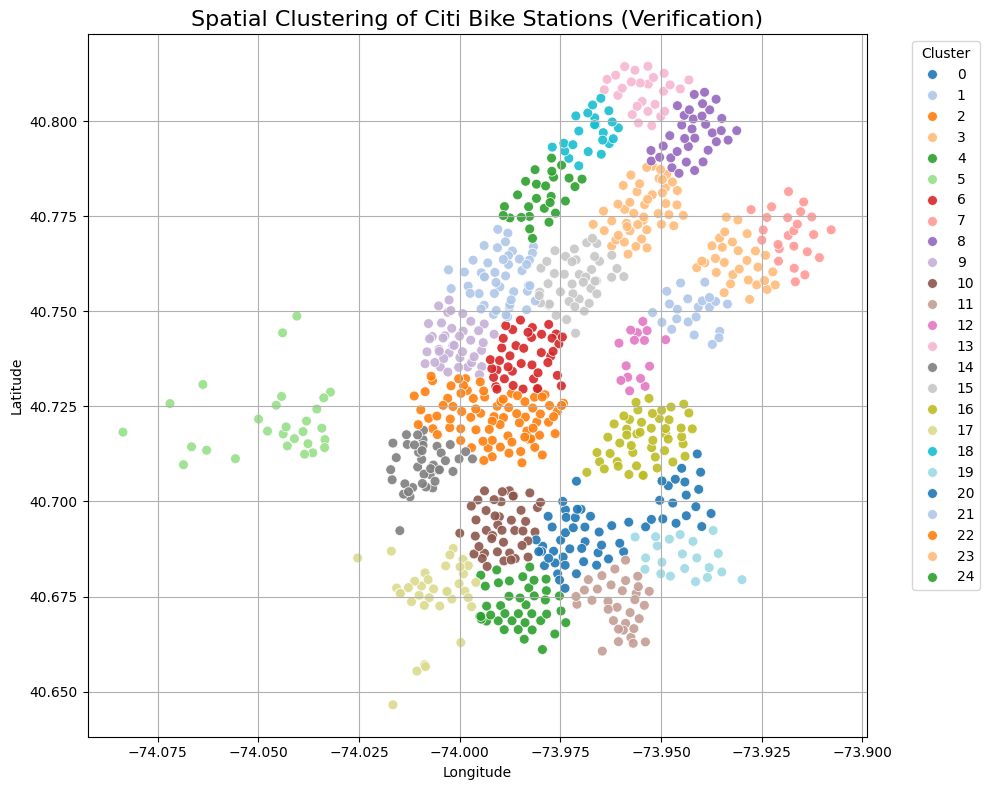

In [19]:
plt.figure(figsize=(10, 8))

sns.scatterplot(
    data=stations_meta,
    x="lon",
    y="lat",
    hue="cluster",
    palette="tab20",
    s=50,
    alpha=0.9
)

plt.title("Spatial Clustering of Citi Bike Stations (Verification)", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

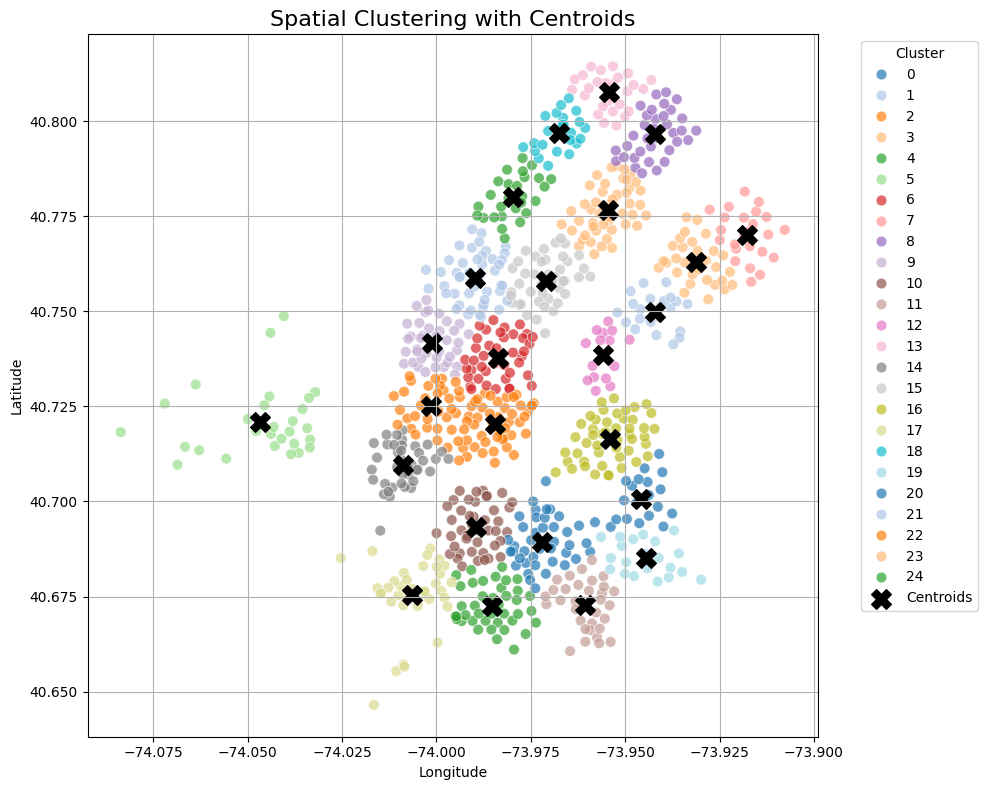

In [20]:
centroids = kmeans.cluster_centers_

plt.figure(figsize=(10, 8))

# Plot stations
sns.scatterplot(
    data=stations_meta,
    x="lon",
    y="lat",
    hue="cluster",
    palette="tab20",
    s=60,
    alpha=0.7
)

# Plot centroids
plt.scatter(
    centroids[:,1],  # lon
    centroids[:,0],  # lat
    s=200,
    c="black",
    marker="X",
    label="Centroids"
)

plt.title("Spatial Clustering with Centroids", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
# Merge cluster labels to hourly demand
hourly_cluster_demand = hourly_demand1.merge(
    stations_meta[['station_id', 'cluster']],
    on='station_id',
    how='left'
)

hourly_cluster_demand = hourly_cluster_demand.drop(columns=["cluster_y"])
hourly_cluster_demand = hourly_cluster_demand.rename(columns={"cluster_x": "cluster"})
hourly_cluster_demand = hourly_cluster_demand.sort_values(["cluster", "hour"])
hourly_cluster_demand = hourly_cluster_demand.set_index("hour")

hourly_cluster_demand.head()


station_id  pickups  dropoffs  hour_of_day  day_of_week  cluster
hour                                                                        
2018-01-01       372.0        0         0            0            0      0.0
2018-01-01       373.0        0         1            0            0      0.0
2018-01-01      3059.0        0         0            0            0      0.0
2018-01-01      3060.0        0         0            0            0      0.0
2018-01-01      3061.0        0         0            0            0      0.0

In [22]:
cluster_ts = (
    hourly_cluster_demand
    .groupby("cluster")
    .resample("h")
    .sum()[["pickups", "dropoffs"]]
    .reset_index()
)
cluster_ts.head()


cluster                hour  pickups  dropoffs
0      0.0 2018-01-01 00:00:00        1         2
1      0.0 2018-01-01 01:00:00        0         0
2      0.0 2018-01-01 02:00:00        0         0
3      0.0 2018-01-01 03:00:00        3         3
4      0.0 2018-01-01 04:00:00        0         0

In [23]:
cluster_ts["hour_of_day"] = cluster_ts["hour"].dt.hour
cluster_ts["day_of_week"] = cluster_ts["hour"].dt.weekday
cluster_ts["month"] = cluster_ts["hour"].dt.month
cluster_ts["day"] = cluster_ts["hour"].dt.day
cluster_ts.head()

cluster                hour  pickups  dropoffs  hour_of_day  day_of_week  \
0      0.0 2018-01-01 00:00:00        1         2            0            0   
1      0.0 2018-01-01 01:00:00        0         0            1            0   
2      0.0 2018-01-01 02:00:00        0         0            2            0   
3      0.0 2018-01-01 03:00:00        3         3            3            0   
4      0.0 2018-01-01 04:00:00        0         0            4            0   

   month  day  
0      1    1  
1      1    1  
2      1    1  
3      1    1  
4      1    1

In [24]:
train = cluster_ts[cluster_ts["month"] <= 10].reset_index(drop=True)

# VALIDATION: November
val = cluster_ts[(cluster_ts["month"] == 11)].reset_index(drop=True)

# TEST: December
test = cluster_ts[(cluster_ts["month"] == 12)].reset_index(drop=True)

print("Train rows:", len(train))
print("Validation rows:", len(val))
print("Test rows:", len(test))

Train rows: 182400
Validation rows: 18000
Test rows: 18600


Baseline Model for Pickups

In [25]:
baseline = (
    train.groupby(["cluster", "hour_of_day"])
    .agg({
        "pickups": "mean",
        "dropoffs": "mean"
    })
    .reset_index()
    .rename(columns={
        "pickups": "baseline_pickups",
        "dropoffs": "baseline_dropoffs"
    })
)

baseline.head()


cluster  hour_of_day  baseline_pickups  baseline_dropoffs
0      0.0            0          5.888158           8.644737
1      0.0            1          3.516447           4.582237
2      0.0            2          2.338816           2.786184
3      0.0            3          1.638158           1.746711
4      0.0            4          1.447368           1.582237

In [26]:
val_pred = val.merge(
    baseline,
    on=["cluster", "hour_of_day"],
    how="left"
)

# Fill missing predictions with global mean if needed
val_pred["baseline_pickups"].fillna(train["pickups"].mean(), inplace=True)
val_pred["baseline_dropoffs"].fillna(train["dropoffs"].mean(), inplace=True)

val_pred.head(20)

C:\Users\Akhil\AppData\Local\Temp\ipykernel_15716\4173580317.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  val_pred["baseline_pickups"].fillna(train["pickups"].mean(), inplace=True)
C:\Users\Akhil\AppData\Local\Temp\ipykernel_15716\4173580317.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always b

cluster                hour  pickups  dropoffs  hour_of_day  day_of_week  \
0       0.0 2018-11-01 00:00:00       12        13            0            3   
1       0.0 2018-11-01 01:00:00        8        14            1            3   
2       0.0 2018-11-01 02:00:00        2         8            2            3   
3       0.0 2018-11-01 03:00:00        4         6            3            3   
4       0.0 2018-11-01 04:00:00        3         4            4            3   
5       0.0 2018-11-01 05:00:00        4         1            5            3   
6       0.0 2018-11-01 06:00:00       13        12            6            3   
7       0.0 2018-11-01 07:00:00       24        18            7            3   
8       0.0 2018-11-01 08:00:00       56        42            8            3   
9       0.0 2018-11-01 09:00:00       49        30            9            3   
10      0.0 2018-11-01 10:00:00       22        13           10            3   
11      0.0 2018-11-01 11:00:00       18        13           11            3   
12      0.0 2018-11-01 12:00:00       26        18           12            3   
13      0.0 2018-11-01 13:00:00       18        19           13            3   
14      0.0 2018-11-01 14:00:00       25        17           14            3   
15      0.0 2018-11-01 15:00:00       29        17           15            3   
16      0.0 2018-11-01 16:00:00       20        27           16            3   
17      0.0 2018-11-01 17:00:00       32        43           17            3   
18      0.0 2018-11-01 18:00:00       35        45           18            3   
19      0.0 2018-11-01 19:00:00       33        53           19            3   

    month  day  baseline_pickups  baseline_dropoffs  
0      11    1          5.888158           8.644737  
1      11    1          3.516447           4.582237  
2      11    1          2.338816           2.786184  
3      11    1          1.638158           1.746711  
4      11    1          1.447368           1.582237  
5      11    1          2.088816           1.348684  
6      11    1          6.947368           4.677632  
7      11    1         15.338816          11.049342  
8      11    1         25.713816          18.532895  
9      11    1         27.286184          16.342105  
10     11    1         19.069079          13.378289  
11     11    1         20.394737          15.536184  
12     11    1         20.753289          17.157895  
13     11    1         21.983553          19.322368  
14     11    1         22.654605          19.976974  
15     11    1         22.052632          21.101974  
16     11    1         22.388158          23.421053  
17     11    1         26.690789          30.776316  
18     11    1         27.990132          38.121711  
19     11    1         24.180921          32.914474

In [27]:
mae_pu = mean_absolute_error(val_pred["pickups"], val_pred["baseline_pickups"])
rmse_pu = np.sqrt(mean_squared_error(val_pred["pickups"], val_pred["baseline_pickups"]))

# Dropoffs
mae_do = mean_absolute_error(val_pred["dropoffs"], val_pred["baseline_dropoffs"])
rmse_do = np.sqrt(mean_squared_error(val_pred["dropoffs"], val_pred["baseline_dropoffs"]))

print("Baseline Pickups MAE:", mae_pu)
print("Baseline Pickups RMSE:", rmse_pu)
print("Baseline Dropoffs MAE:", mae_do)
print("Baseline Dropoffs RMSE:", rmse_do)

Baseline Pickups MAE: 33.46804897660818
Baseline Pickups RMSE: 67.93680930587101
Baseline Dropoffs MAE: 33.141664108187136
Baseline Dropoffs RMSE: 68.59792627964985


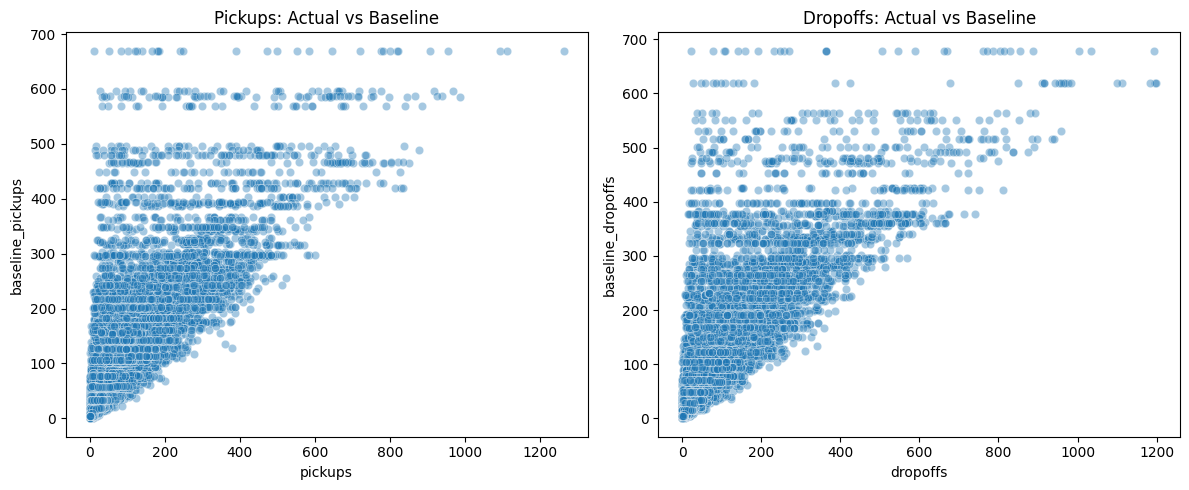

In [28]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.scatterplot(x=val_pred["pickups"], y=val_pred["baseline_pickups"], alpha=0.4)
plt.title("Pickups: Actual vs Baseline")

plt.subplot(1,2,2)
sns.scatterplot(x=val_pred["dropoffs"], y=val_pred["baseline_dropoffs"], alpha=0.4)
plt.title("Dropoffs: Actual vs Baseline")

plt.tight_layout()
plt.show()


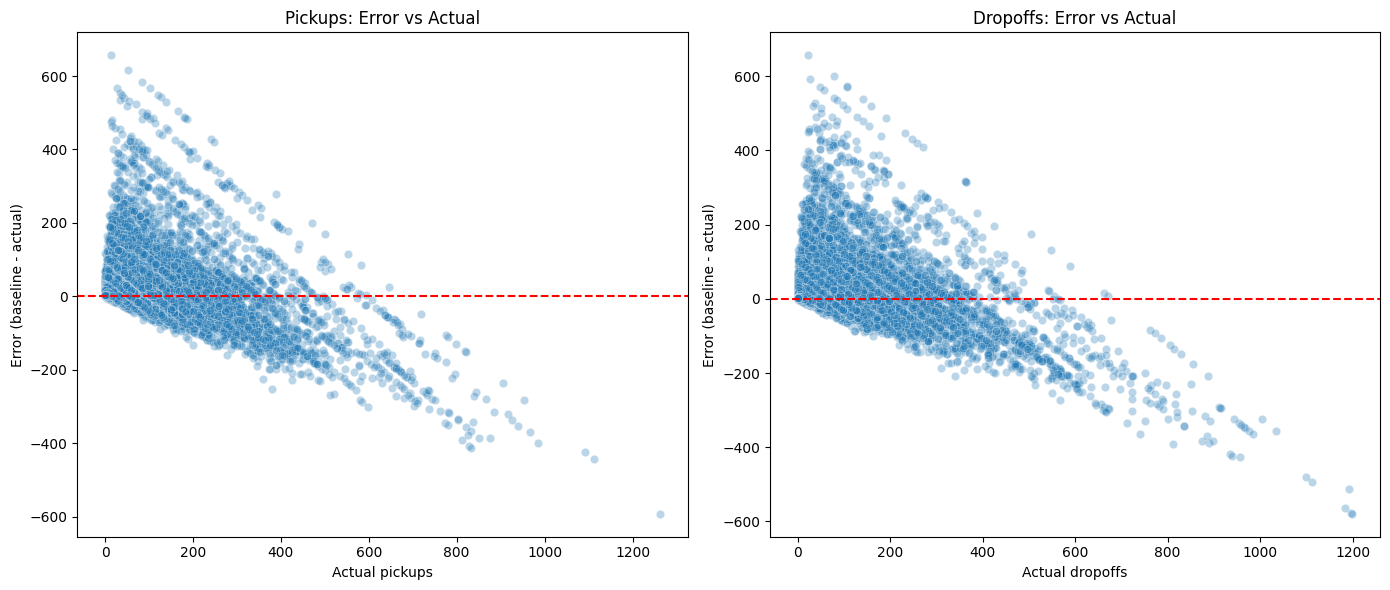

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

val_pred["error_pickups"] = val_pred["baseline_pickups"] - val_pred["pickups"]
val_pred["error_dropoffs"] = val_pred["baseline_dropoffs"] - val_pred["dropoffs"]

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.scatterplot(x=val_pred["pickups"], y=val_pred["error_pickups"], alpha=0.3)
plt.axhline(0, color="red", linestyle="--")
plt.title("Pickups: Error vs Actual")
plt.xlabel("Actual pickups")
plt.ylabel("Error (baseline - actual)")

plt.subplot(1,2,2)
sns.scatterplot(x=val_pred["dropoffs"], y=val_pred["error_dropoffs"], alpha=0.3)
plt.axhline(0, color="red", linestyle="--")
plt.title("Dropoffs: Error vs Actual")
plt.xlabel("Actual dropoffs")
plt.ylabel("Error (baseline - actual)")
plt.tight_layout()
plt.show()


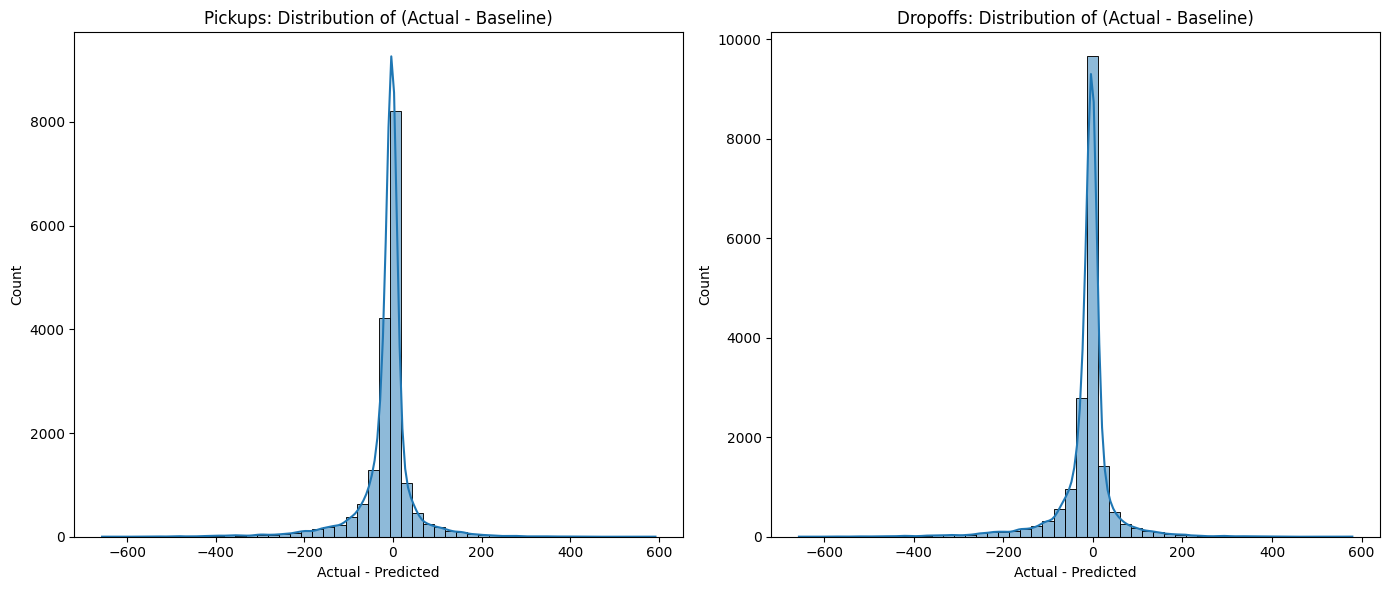

In [30]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.histplot(val_pred["pickups"] - val_pred["baseline_pickups"], bins=50, kde=True)
plt.title("Pickups: Distribution of (Actual - Baseline)")
plt.xlabel("Actual - Predicted")

plt.subplot(1,2,2)
sns.histplot(val_pred["dropoffs"] - val_pred["baseline_dropoffs"], bins=50, kde=True)
plt.title("Dropoffs: Distribution of (Actual - Baseline)")
plt.xlabel("Actual - Predicted")

plt.tight_layout()
plt.show()


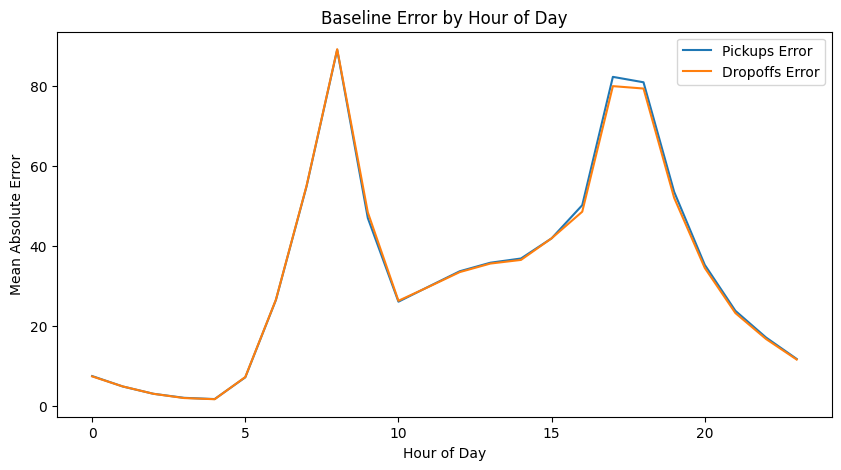

In [31]:
hourly_err = (
    val_pred
    .assign(err_pu = abs(val_pred["baseline_pickups"] - val_pred["pickups"]),
            err_do = abs(val_pred["baseline_dropoffs"] - val_pred["dropoffs"]))
    .groupby("hour_of_day")[["err_pu", "err_do"]]
    .mean()
)

plt.figure(figsize=(10,5))
plt.plot(hourly_err.index, hourly_err["err_pu"], label="Pickups Error")
plt.plot(hourly_err.index, hourly_err["err_do"], label="Dropoffs Error")
plt.xlabel("Hour of Day")
plt.ylabel("Mean Absolute Error")
plt.title("Baseline Error by Hour of Day")
plt.legend()
plt.show()


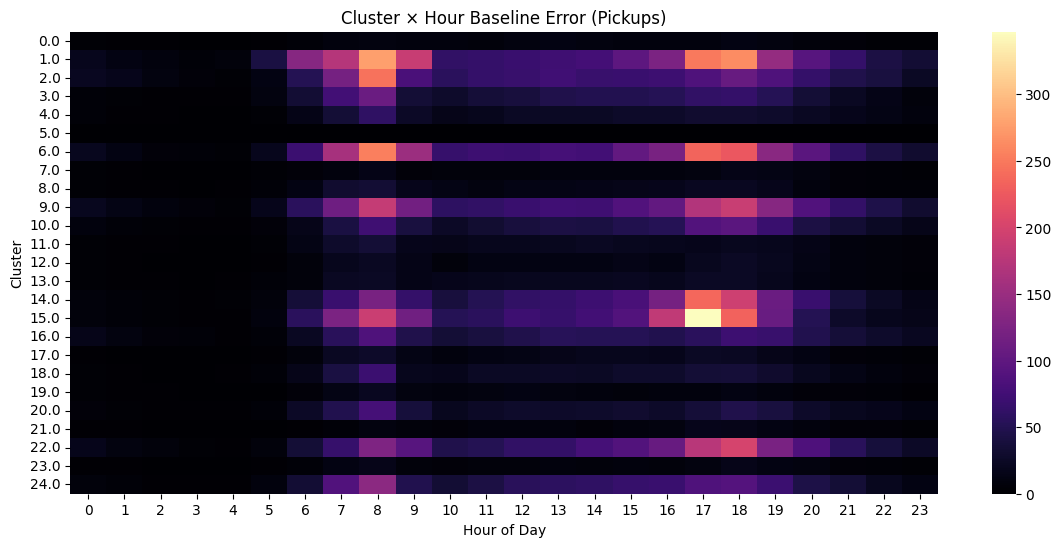

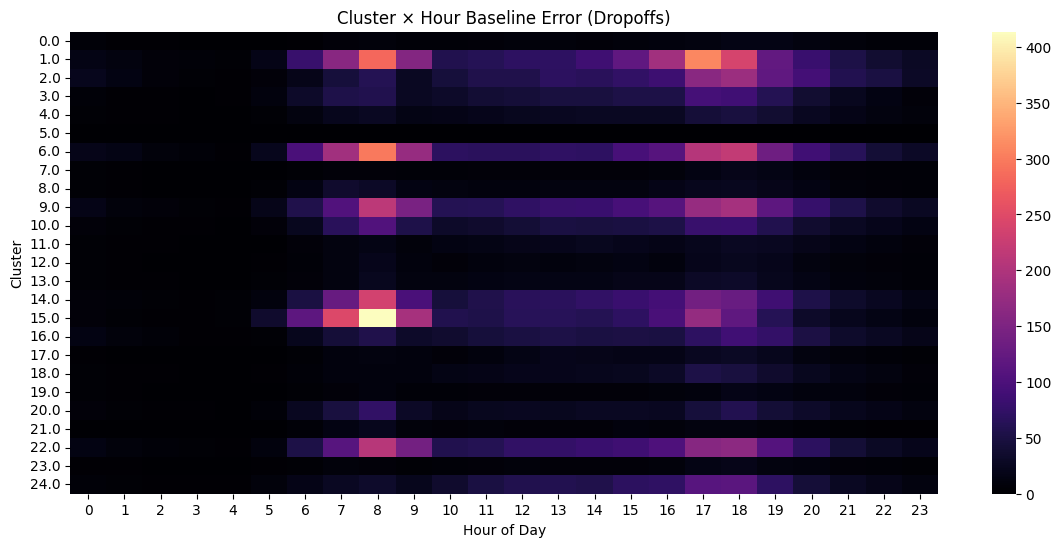

In [32]:


val_pred["abs_error_pu"] = np.abs(val_pred["baseline_pickups"] - val_pred["pickups"])
val_pred["abs_error_do"] = np.abs(val_pred["baseline_dropoffs"] - val_pred["dropoffs"])

heat = val_pred.groupby(["cluster", "hour_of_day"])[["abs_error_pu", "abs_error_do"]].mean()

plt.figure(figsize=(14,6))
sns.heatmap(heat["abs_error_pu"].unstack(), cmap="magma")
plt.title("Cluster × Hour Baseline Error (Pickups)")
plt.xlabel("Hour of Day")
plt.ylabel("Cluster")
plt.show()

plt.figure(figsize=(14,6))
sns.heatmap(heat["abs_error_do"].unstack(), cmap="magma")
plt.title("Cluster × Hour Baseline Error (Dropoffs)")
plt.xlabel("Hour of Day")
plt.ylabel("Cluster")
plt.show()


In [33]:
df_long = val_pred.copy()

# Melt pickups
df_pick = df_long.melt(
    id_vars=["cluster", "hour"],
    value_vars=["pickups", "baseline_pickups"],
    var_name="type",
    value_name="value"
)
df_pick["metric"] = "pickups"

# Melt dropoffs
df_drop = df_long.melt(
    id_vars=["cluster", "hour"],
    value_vars=["dropoffs", "baseline_dropoffs"],
    var_name="type",
    value_name="value"
)
df_drop["metric"] = "dropoffs"

# Combine
df_melt = pd.concat([df_pick, df_drop], ignore_index=True)
df_melt

cluster                hour               type       value    metric
0          0.0 2018-11-01 00:00:00            pickups   12.000000   pickups
1          0.0 2018-11-01 01:00:00            pickups    8.000000   pickups
2          0.0 2018-11-01 02:00:00            pickups    2.000000   pickups
3          0.0 2018-11-01 03:00:00            pickups    4.000000   pickups
4          0.0 2018-11-01 04:00:00            pickups    3.000000   pickups
...        ...                 ...                ...         ...       ...
71995     24.0 2018-11-30 19:00:00  baseline_dropoffs  168.549342  dropoffs
71996     24.0 2018-11-30 20:00:00  baseline_dropoffs  103.207237  dropoffs
71997     24.0 2018-11-30 21:00:00  baseline_dropoffs   70.509868  dropoffs
71998     24.0 2018-11-30 22:00:00  baseline_dropoffs   47.855263  dropoffs
71999     24.0 2018-11-30 23:00:00  baseline_dropoffs   28.338816  dropoffs

[72000 rows x 5 columns]

Index(['cluster', 'hour', 'pickups', 'dropoffs', 'hour_of_day', 'day_of_week',
       'month', 'day', 'baseline_pickups', 'baseline_dropoffs',
       'error_pickups', 'error_dropoffs', 'abs_error_pu', 'abs_error_do'],
      dtype='object')


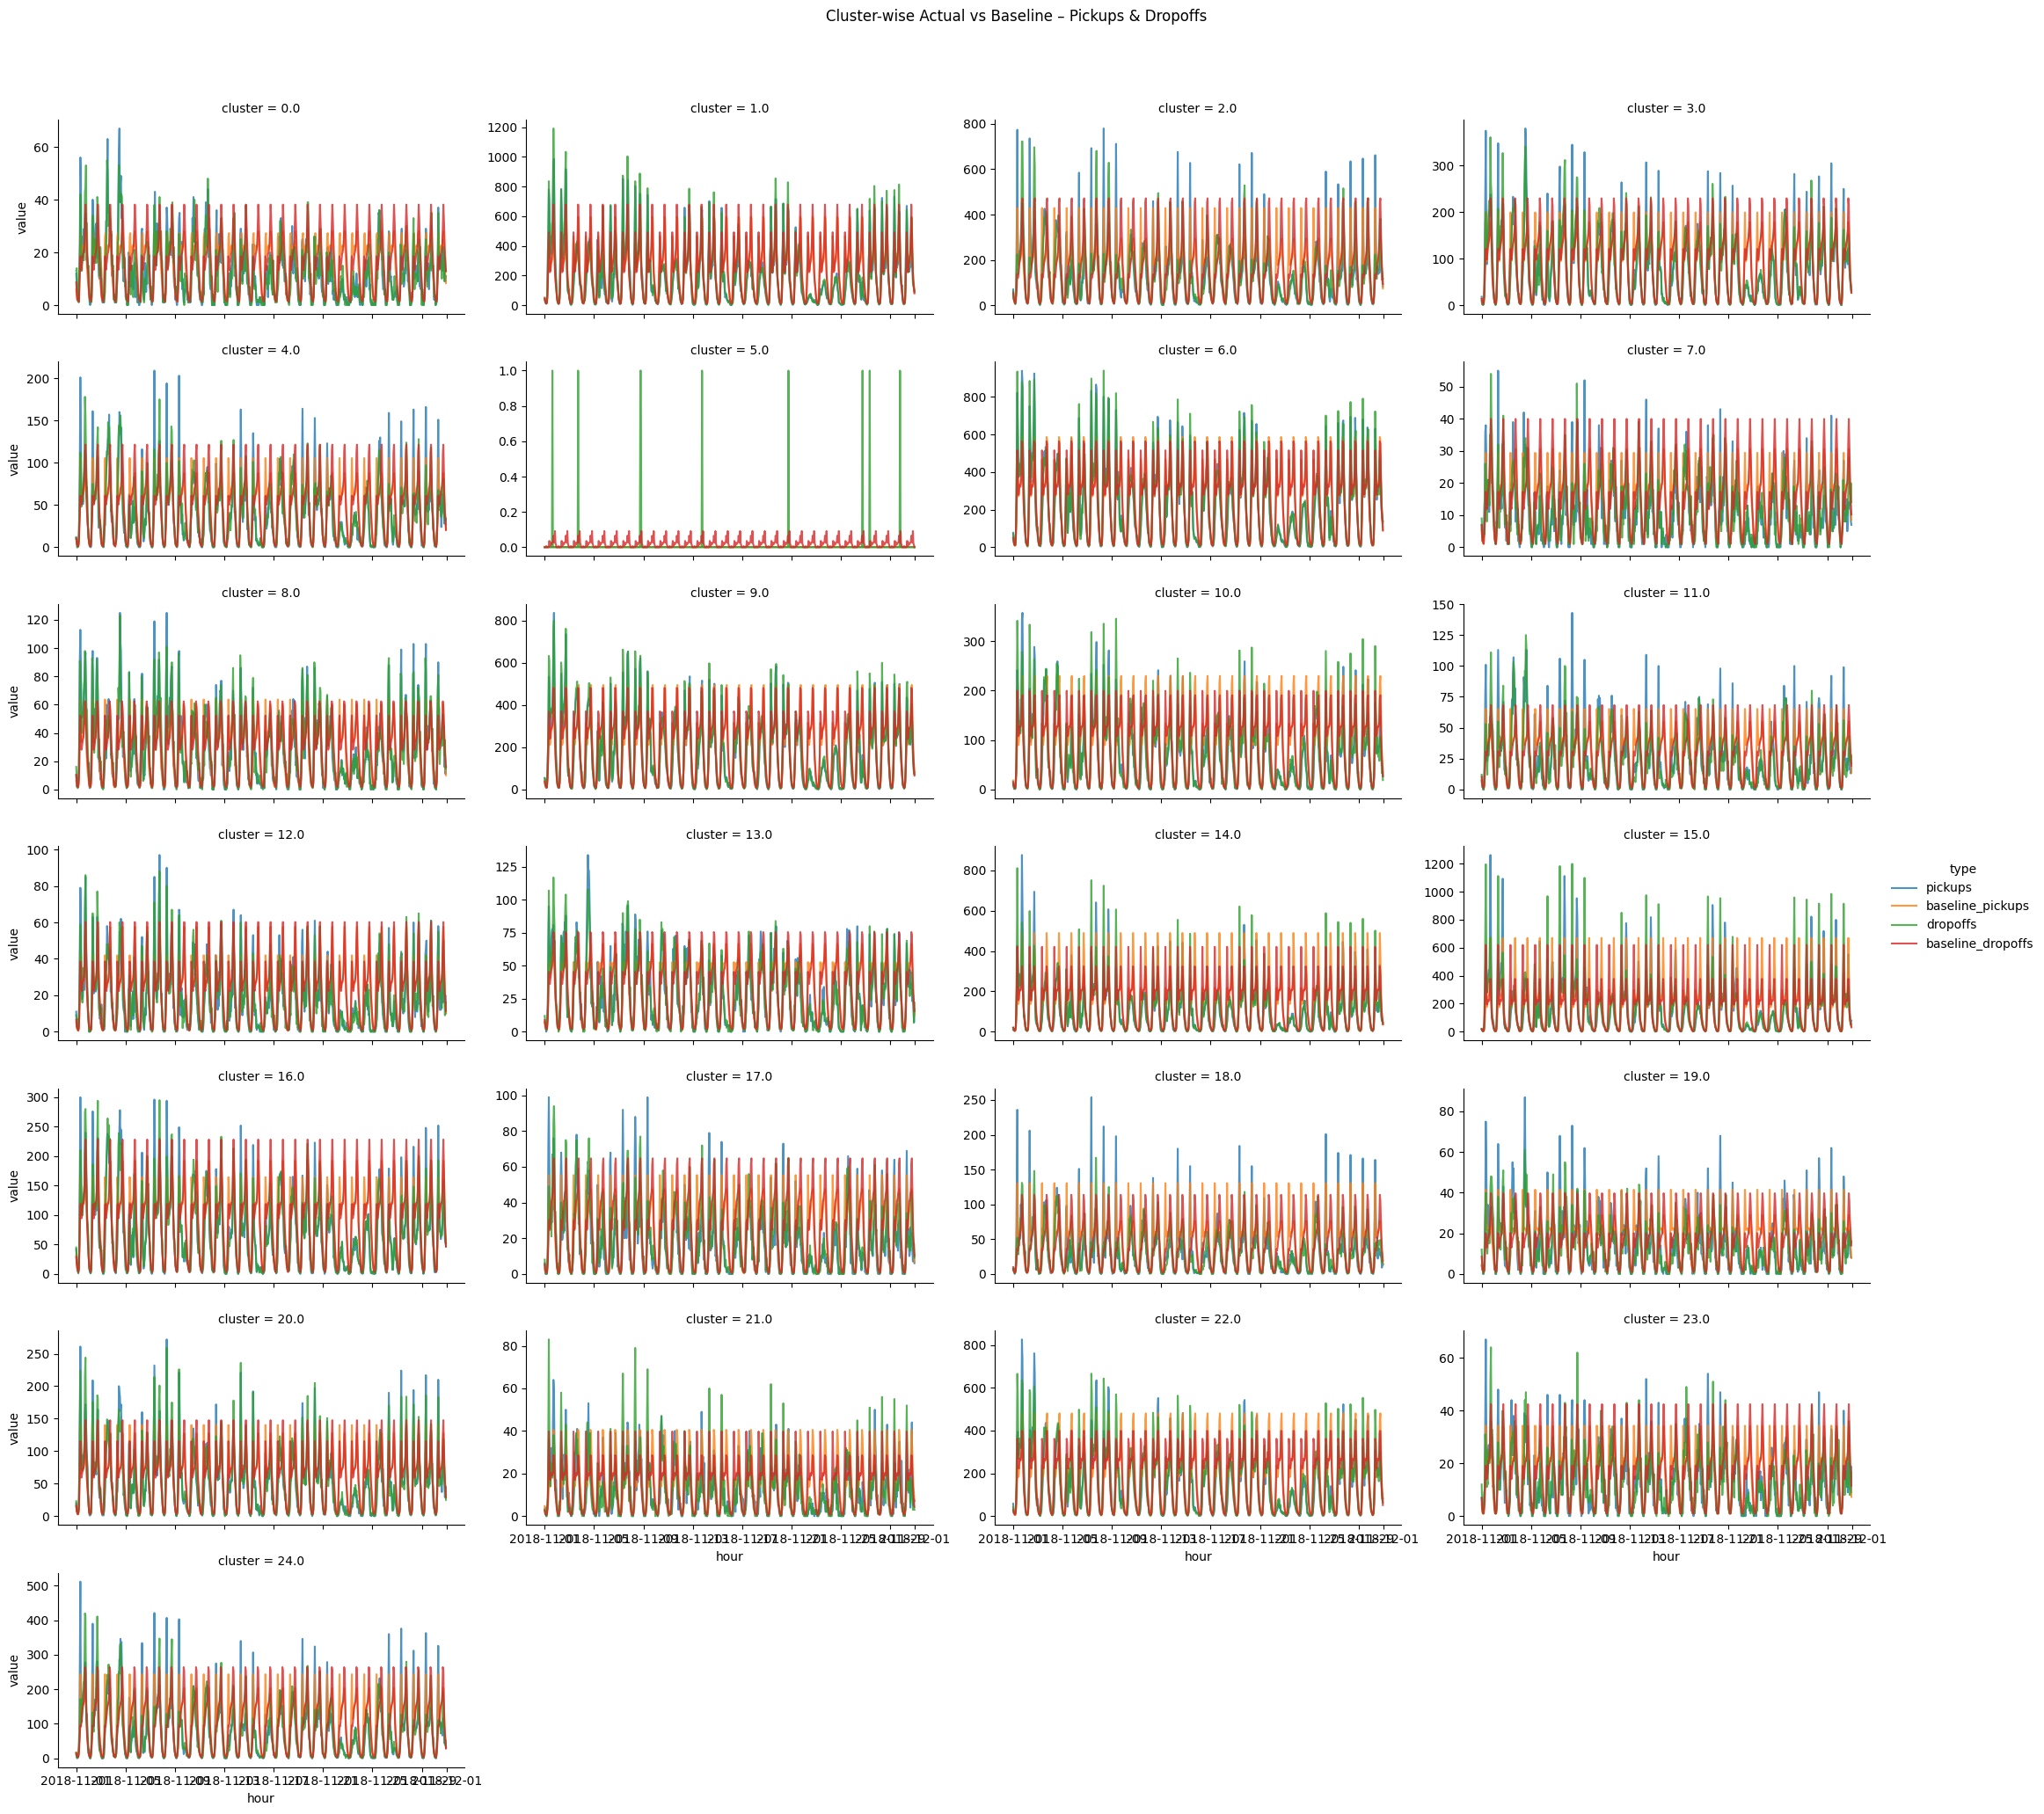

In [34]:
df_long = val_pred.copy()
print(df_long.columns)

df_long = val_pred.copy()

df_pick = df_long.melt(
    id_vars=["cluster", "hour"],
    value_vars=["pickups", "baseline_pickups"],
    var_name="type",
    value_name="value"
)
df_pick["metric"] = "pickups"

df_drop = df_long.melt(
    id_vars=["cluster", "hour"],
    value_vars=["dropoffs", "baseline_dropoffs"],
    var_name="type",
    value_name="value"
)
df_drop["metric"] = "dropoffs"
df_melt = pd.concat([df_pick, df_drop], ignore_index=True)

# Small multiple plots
g = sns.FacetGrid(
    df_melt,
    col="cluster",
    col_wrap=4,
    height=3,
    aspect=1.8,
    sharey=False,
    hue="type"     # actual vs baseline
)

g.map(sns.lineplot, "hour", "value", alpha=0.8)
g.add_legend()

plt.subplots_adjust(top=0.92)
g.fig.suptitle("Cluster-wise Actual vs Baseline – Pickups & Dropoffs")
plt.show()

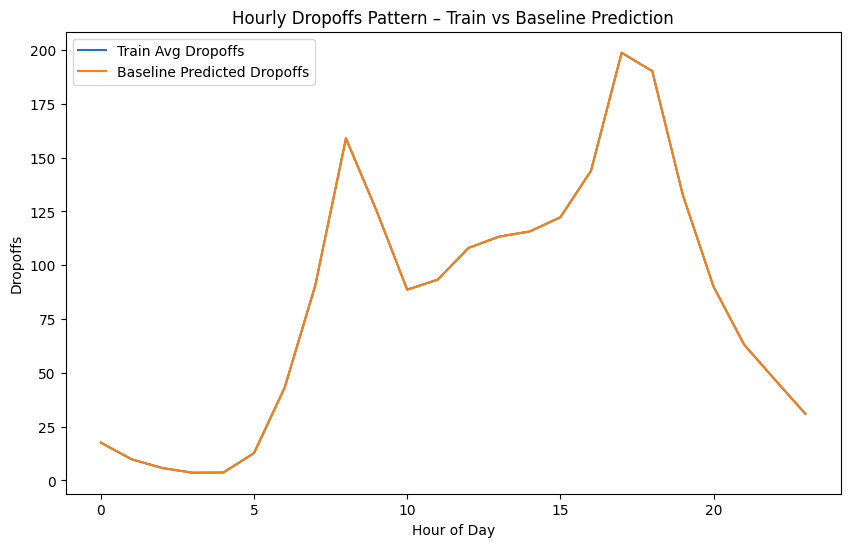

In [37]:
plt.figure(figsize=(10,6))

# Train hourly average dropoffs
sns.lineplot(
    data=train.groupby("hour_of_day")["dropoffs"].mean().reset_index(),
    x="hour_of_day", 
    y="dropoffs", 
    label="Train Avg Dropoffs"
)

# Baseline predicted dropoffs
sns.lineplot(
    data=val_pred.groupby("hour_of_day")["baseline_dropoffs"].mean().reset_index(),
    x="hour_of_day", 
    y="baseline_dropoffs", 
    label="Baseline Predicted Dropoffs"
)

plt.title("Hourly Dropoffs Pattern – Train vs Baseline Prediction")
plt.xlabel("Hour of Day")
plt.ylabel("Dropoffs")
plt.legend()
plt.show()


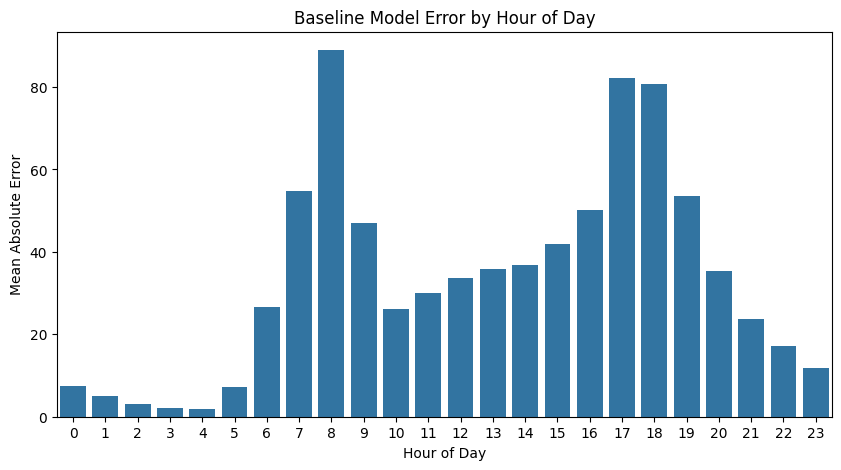

In [ ]:
#baseline weakness
val_pred["abs_error"] = abs(val_pred["pickups"] - val_pred["baseline_pred"])

df_err = (
    val_pred.groupby("hour_of_day")["abs_error"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(10,5))
sns.barplot(data=df_err, x="hour_of_day", y="abs_error")
plt.title("Baseline Model Error by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Mean Absolute Error")
plt.show()


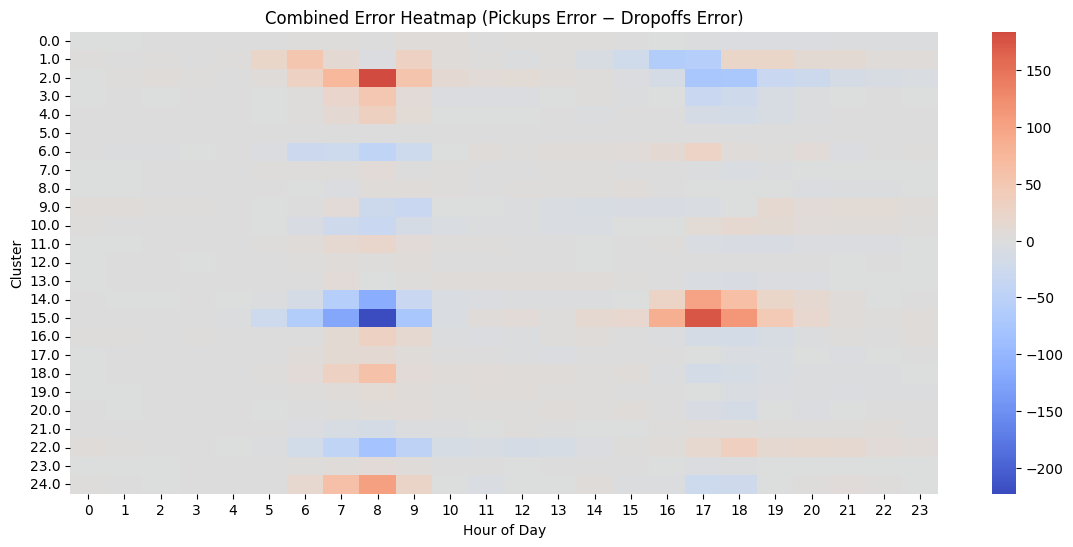

In [38]:
val_pred["combined_error"] = val_pred["abs_error_pu"] - val_pred["abs_error_do"]

heat_combined = (
    val_pred.groupby(["cluster", "hour_of_day"])["combined_error"]
            .mean()
            .reset_index()
            .pivot(index="cluster", columns="hour_of_day", values="combined_error")
)

plt.figure(figsize=(14, 6))
sns.heatmap(
    heat_combined, 
    cmap="coolwarm",     # red = worse for dropoffs, blue = worse for pickups
    center=0,            # zero difference is white
    linewidths=0
)
plt.title("Combined Error Heatmap (Pickups Error − Dropoffs Error)")
plt.xlabel("Hour of Day")
plt.ylabel("Cluster")
plt.show()


# Random Forest Model

In [40]:
train["lag1_pu"] = train.groupby("cluster")["pickups"].shift(1)
val["lag1_pu"]   = val.groupby("cluster")["pickups"].shift(1)
test["lag1_pu"]  = test.groupby("cluster")["pickups"].shift(1)

# Lag for dropoffs
train["lag1_do"] = train.groupby("cluster")["dropoffs"].shift(1)
val["lag1_do"]   = val.groupby("cluster")["dropoffs"].shift(1)
test["lag1_do"]  = test.groupby("cluster")["dropoffs"].shift(1)

# Fill NA
train.fillna(0, inplace=True)
val.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [42]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

feature_cols = [
    "cluster",
    "hour_of_day",
    "day_of_week",
    "month",
    "lag1_pu",
    "lag1_do"
]

X_train = train[feature_cols]
y_train = train[["pickups", "dropoffs"]]

multi_rf = MultiOutputRegressor(
    RandomForestRegressor(
        n_estimators=200,
        max_depth=15,
        min_samples_split=10,
        n_jobs=-1,
        random_state=42
    )
)

multi_rf.fit(X_train, y_train)


MultiOutputRegressor(estimator=RandomForestRegressor(max_depth=15,
                                                     min_samples_split=10,
                                                     n_estimators=200,
                                                     n_jobs=-1,
                                                     random_state=42))

In [43]:
val[["pred_pickups", "pred_dropoffs"]] = multi_rf.predict(val[feature_cols])
test[["pred_pickups", "pred_dropoffs"]] = multi_rf.predict(test[feature_cols])


In [44]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Pickups
mae_pu = mean_absolute_error(val["pickups"], val["pred_pickups"])
rmse_pu = np.sqrt(mean_squared_error(val["pickups"], val["pred_pickups"]))

# Dropoffs
mae_do = mean_absolute_error(val["dropoffs"], val["pred_dropoffs"])
rmse_do = np.sqrt(mean_squared_error(val["dropoffs"], val["pred_dropoffs"]))

print("RF Multi-out Pickups MAE:", mae_pu)
print("RF Multi-out Pickups RMSE:", rmse_pu)
print("RF Multi-out Dropoffs MAE:", mae_do)
print("RF Multi-out Dropoffs RMSE:", rmse_do)


RF Multi-out Pickups MAE: 11.195470345426278
RF Multi-out Pickups RMSE: 22.313386542928715
RF Multi-out Dropoffs MAE: 11.299267301887662
RF Multi-out Dropoffs RMSE: 22.333241945660284


In [45]:
print([col for col in train.columns if 'lag' in col])


['lag1_pu', 'lag1_do']


In [51]:
from xgboost import XGBRegressor
feature_cols = ["cluster", "hour_of_day", "day_of_week", "month", "lag1_pu", "lag1_do"]
xgb_pu = XGBRegressor(
    n_estimators=400,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    n_jobs=-1,
    random_state=42,
    tree_method="hist"
)

xgb_pu.fit(
    train[feature_cols], train["pickups"],
    eval_set=[(val[feature_cols], val["pickups"])],
    #early_stopping_rounds=50,
    verbose=False
)
xgb_do = XGBRegressor(
    n_estimators=400,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    n_jobs=-1,
    random_state=42,
    tree_method="hist"
)

xgb_do.fit(
    train[feature_cols], train["dropoffs"],
    eval_set=[(val[feature_cols], val["dropoffs"])],
    #early_stopping_rounds=50,
    verbose=False
)
val["pred_pickups"]  = xgb_pu.predict(val[feature_cols])
val["pred_dropoffs"] = xgb_do.predict(val[feature_cols])


In [67]:
mae_pu = mean_absolute_error(val["pickups"], val["pred_pickups"])
rmse_pu = np.sqrt(mean_squared_error(val["pickups"], val["pred_pickups"]))

mae_do = mean_absolute_error(val["dropoffs"], val["pred_dropoffs"])
rmse_do = np.sqrt(mean_squared_error(val["dropoffs"], val["pred_dropoffs"]))

val.head()

print("XGBoost Pickups MAE:", mae_pu)
print("XGBoost Pickups RMSE:", rmse_pu)
print("XGBoost Dropoffs MAE:", mae_do)
print("XGBoost Dropoffs RMSE:", rmse_do)
val.head(100)

XGBoost Pickups MAE: 11.399484634399414
XGBoost Pickups RMSE: 22.479903677194383
XGBoost Dropoffs MAE: 11.806862831115723
XGBoost Dropoffs RMSE: 23.35135078525638


cluster                hour  pickups  dropoffs  hour_of_day  day_of_week  \
0       0.0 2018-11-01 00:00:00       12        13            0            3   
1       0.0 2018-11-01 01:00:00        8        14            1            3   
2       0.0 2018-11-01 02:00:00        2         8            2            3   
3       0.0 2018-11-01 03:00:00        4         6            3            3   
4       0.0 2018-11-01 04:00:00        3         4            4            3   
..      ...                 ...      ...       ...          ...          ...   
95      0.0 2018-11-04 23:00:00       10         7           23            6   
96      0.0 2018-11-05 00:00:00        3         9            0            0   
97      0.0 2018-11-05 01:00:00        3         2            1            0   
98      0.0 2018-11-05 02:00:00        4         3            2            0   
99      0.0 2018-11-05 03:00:00        0         0            3            0   

    month  day  lag1_pu  lag1_do  pred_pickups  pred_dropoffs  abs_err_pu  \
0      11    1      0.0      0.0      0.561183       0.532931   11.438817   
1      11    1     12.0     13.0      6.427153       7.054914    1.572847   
2      11    1      8.0     14.0      4.722535       7.037211    2.722535   
3      11    1      2.0      8.0      1.994872       3.645129    2.005128   
4      11    1      4.0      6.0      5.539244       5.658828    2.539244   
..    ...  ...      ...      ...           ...            ...         ...   
95     11    4      9.0     18.0      8.020187      13.565603    1.979813   
96     11    5     10.0      7.0      4.995479       5.683470    1.995479   
97     11    5      3.0      9.0      2.426867       4.089823    0.573133   
98     11    5      3.0      2.0      1.636929       0.980647    2.363071   
99     11    5      4.0      3.0      2.106175       1.701077    2.106175   

    abs_err_do  
0    12.467069  
1     6.945086  
2     0.962789  
3     2.354871  
4     1.658828  
..         ...  
95    6.565603  
96    3.316530  
97    2.089823  
98    2.019353  
99    1.701077  

[100 rows x 14 columns]

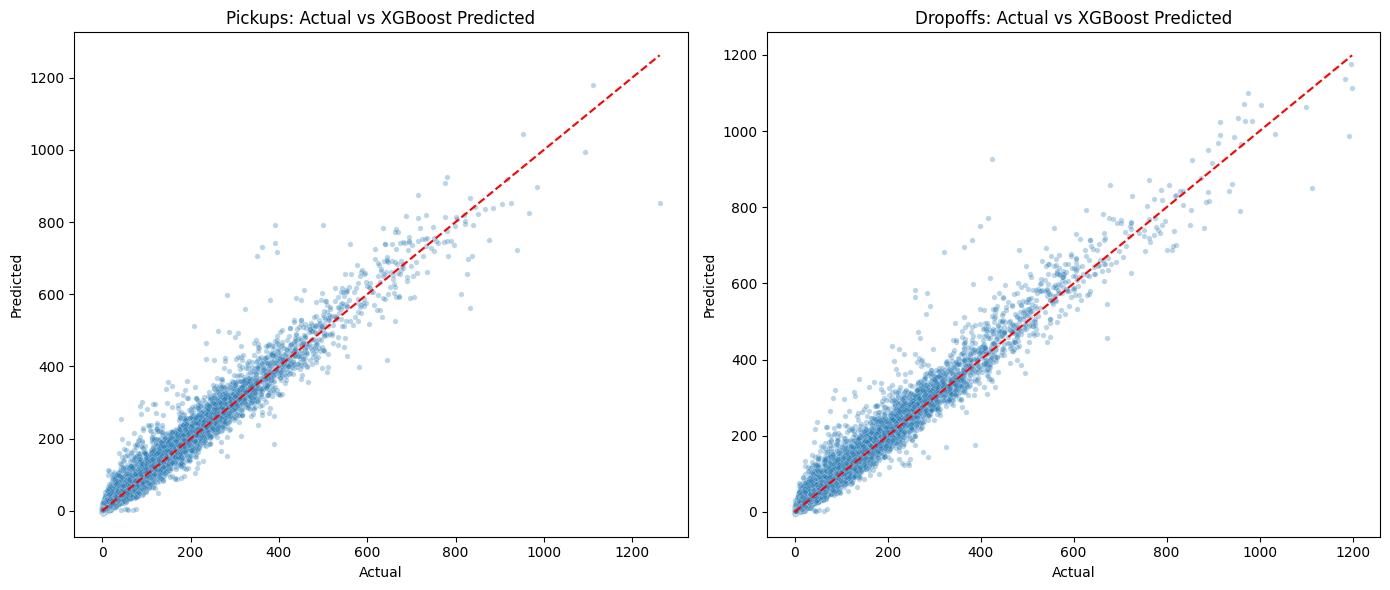

In [53]:
plt.figure(figsize=(14,6))

# PICKUPS
plt.subplot(1,2,1)
sns.scatterplot(x=val["pickups"], y=val["pred_pickups"], alpha=0.3, s=15)
plt.plot([0, max(val["pickups"])], [0, max(val["pickups"])], 'r--')
plt.title("Pickups: Actual vs XGBoost Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")

# DROPOFFS
plt.subplot(1,2,2)
sns.scatterplot(x=val["dropoffs"], y=val["pred_dropoffs"], alpha=0.3, s=15)
plt.plot([0, max(val["dropoffs"])], [0, max(val["dropoffs"])], 'r--')
plt.title("Dropoffs: Actual vs XGBoost Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")

plt.tight_layout()
plt.show()

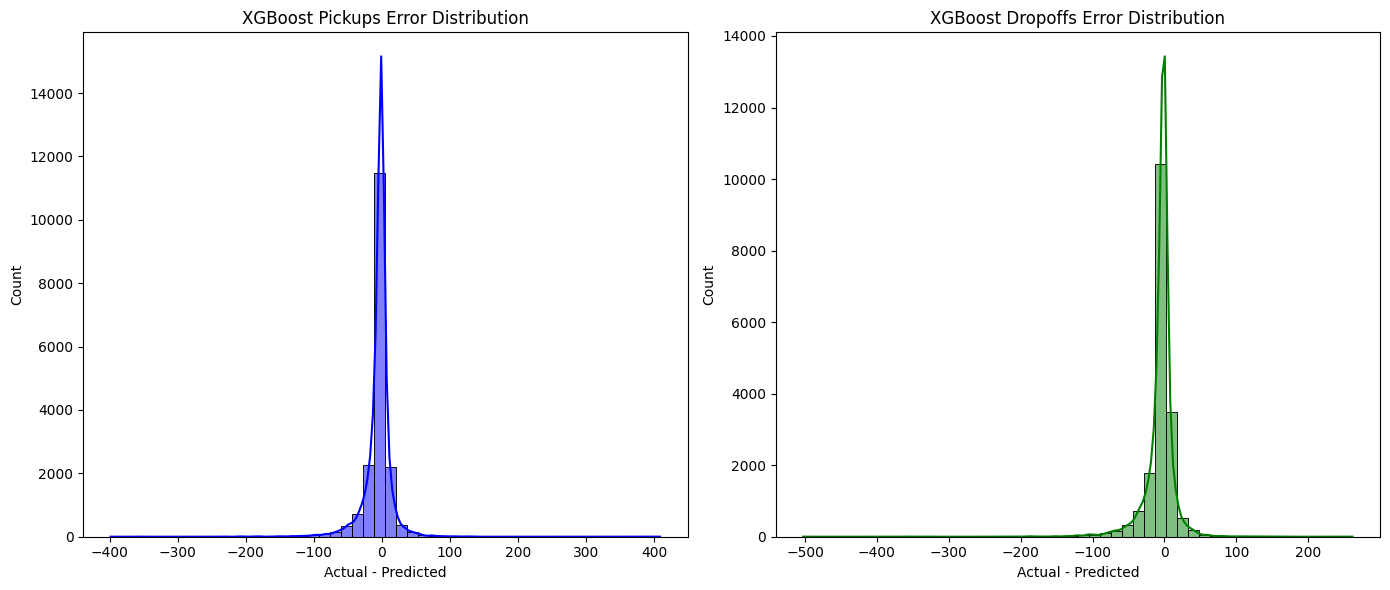

In [54]:
plt.figure(figsize=(14,6))

# PICKUPS
plt.subplot(1,2,1)
sns.histplot(val["pickups"] - val["pred_pickups"], bins=50, kde=True, color="blue")
plt.title("XGBoost Pickups Error Distribution")
plt.xlabel("Actual - Predicted")

# DROPOFFS
plt.subplot(1,2,2)
sns.histplot(val["dropoffs"] - val["pred_dropoffs"], bins=50, kde=True, color="green")
plt.title("XGBoost Dropoffs Error Distribution")
plt.xlabel("Actual - Predicted")

plt.tight_layout()
plt.show()


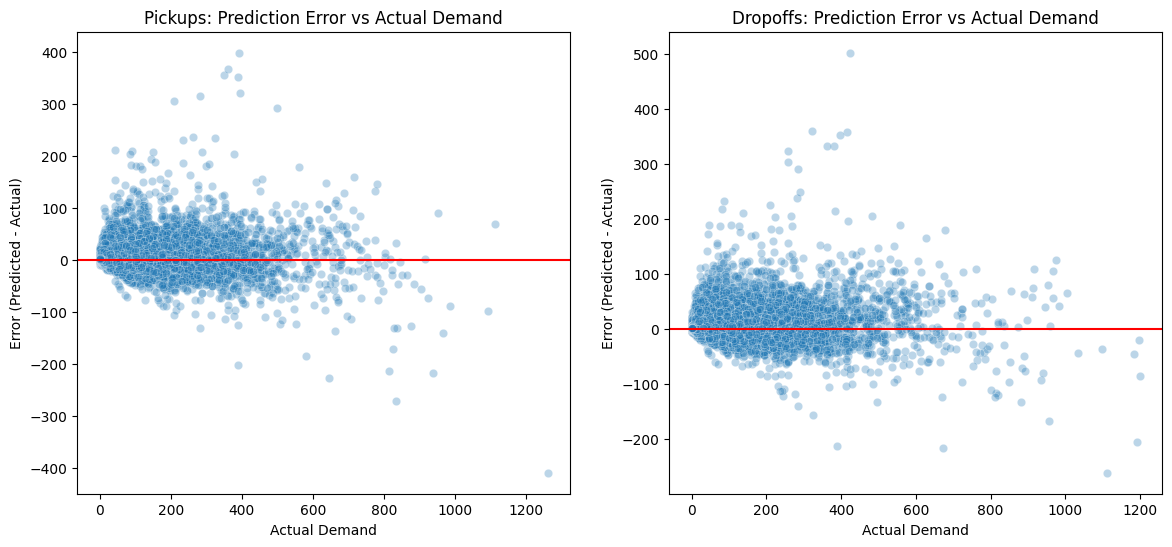

In [55]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.scatterplot(
    x=val["pickups"],
    y=val["pred_pickups"] - val["pickups"],
    alpha=0.3
)
plt.axhline(0, color="red")
plt.title("Pickups: Prediction Error vs Actual Demand")
plt.xlabel("Actual Demand")
plt.ylabel("Error (Predicted - Actual)")

plt.subplot(1,2,2)
sns.scatterplot(
    x=val["dropoffs"],
    y=val["pred_dropoffs"] - val["dropoffs"],
    alpha=0.3
)
plt.axhline(0, color="red")
plt.title("Dropoffs: Prediction Error vs Actual Demand")
plt.xlabel("Actual Demand")
plt.ylabel("Error (Predicted - Actual)")
plt.show()


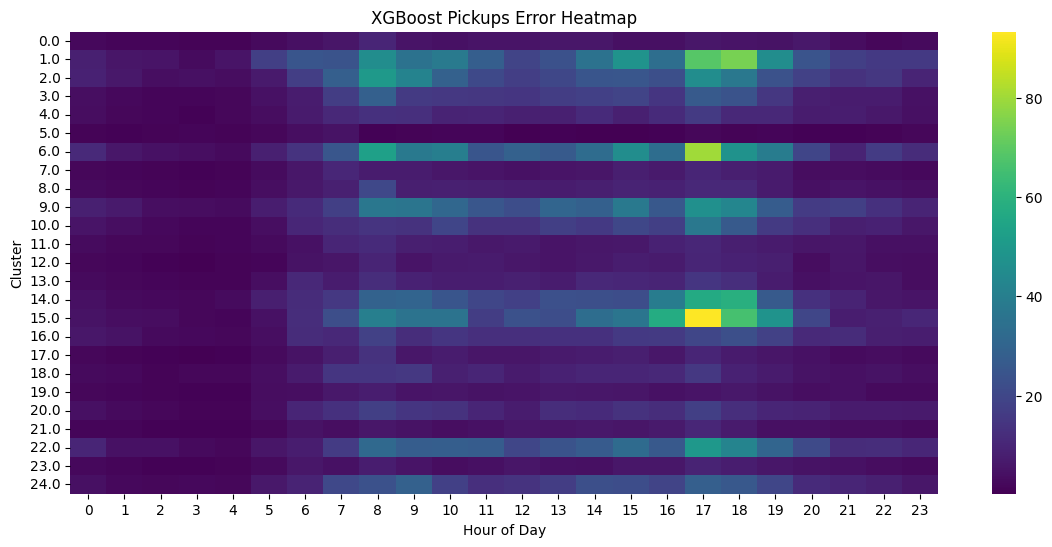

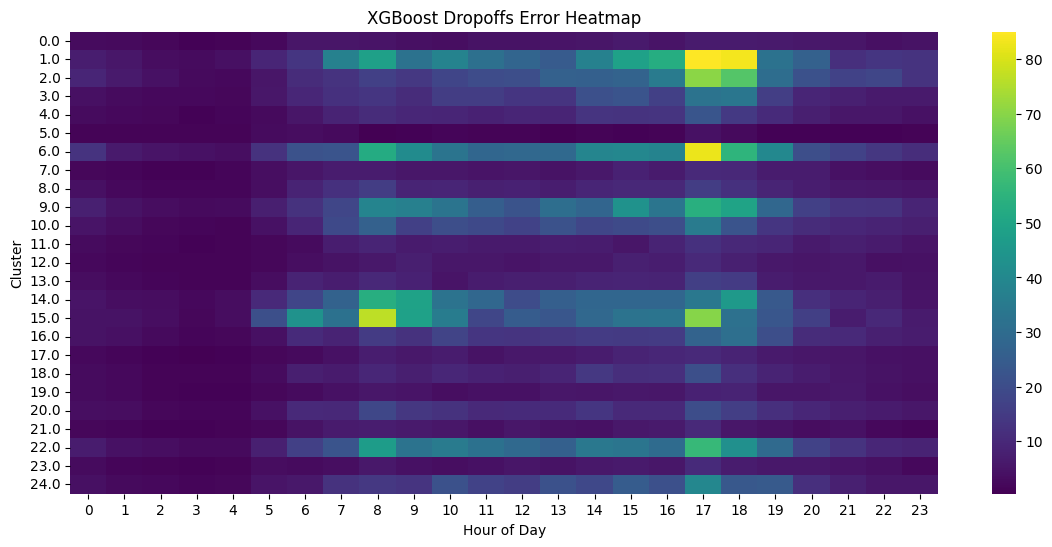

In [56]:
val["abs_err_pu"] = abs(val["pickups"] - val["pred_pickups"])
val["abs_err_do"] = abs(val["dropoffs"] - val["pred_dropoffs"])

heat_pu = (
    val.groupby(["cluster", "hour_of_day"])["abs_err_pu"]
       .mean()
       .unstack()
)

heat_do = (
    val.groupby(["cluster", "hour_of_day"])["abs_err_do"]
       .mean()
       .unstack()
)

plt.figure(figsize=(14,6))
sns.heatmap(heat_pu, cmap="viridis")
plt.title("XGBoost Pickups Error Heatmap")
plt.xlabel("Hour of Day")
plt.ylabel("Cluster")
plt.show()

plt.figure(figsize=(14,6))
sns.heatmap(heat_do, cmap="viridis")
plt.title("XGBoost Dropoffs Error Heatmap")
plt.xlabel("Hour of Day")
plt.ylabel("Cluster")
plt.show()


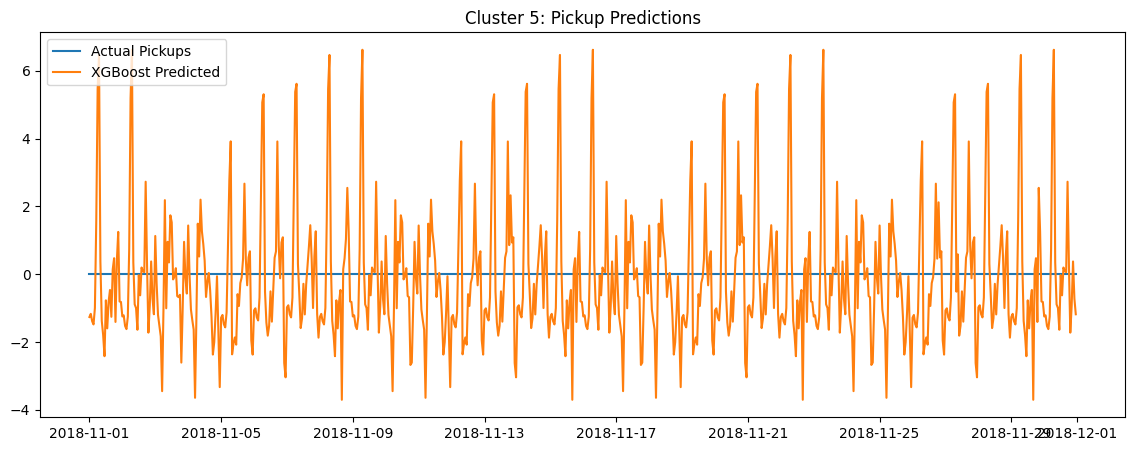

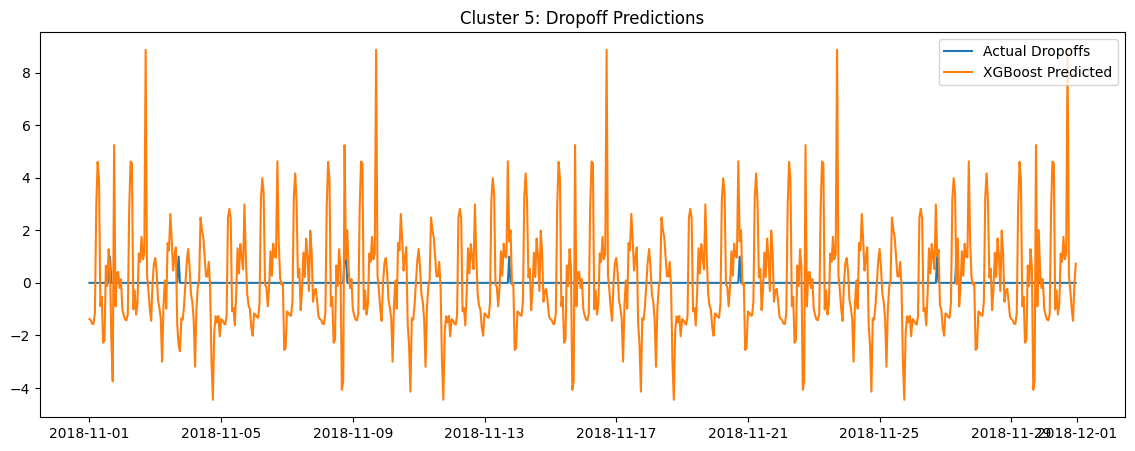

In [57]:
cluster_id = 5
dfc = val[val["cluster"] == cluster_id]

plt.figure(figsize=(14,5))
plt.plot(dfc["hour"], dfc["pickups"], label="Actual Pickups")
plt.plot(dfc["hour"], dfc["pred_pickups"], label="XGBoost Predicted")
plt.legend()
plt.title(f"Cluster {cluster_id}: Pickup Predictions")
plt.show()
plt.figure(figsize=(14,5))
plt.plot(dfc["hour"], dfc["dropoffs"], label="Actual Dropoffs")
plt.plot(dfc["hour"], dfc["pred_dropoffs"], label="XGBoost Predicted")
plt.legend()
plt.title(f"Cluster {cluster_id}: Dropoff Predictions")
plt.show()

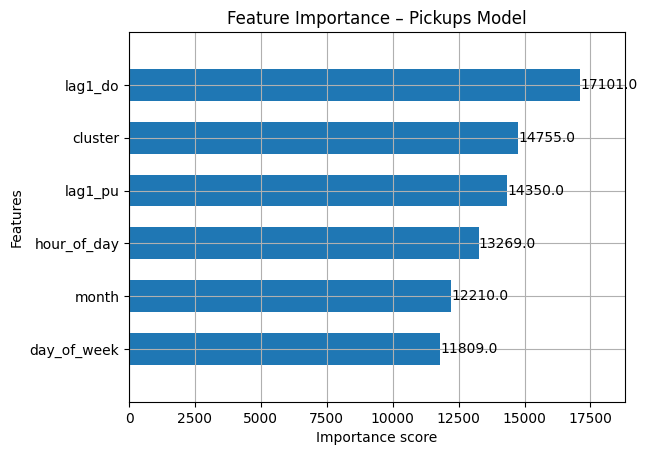

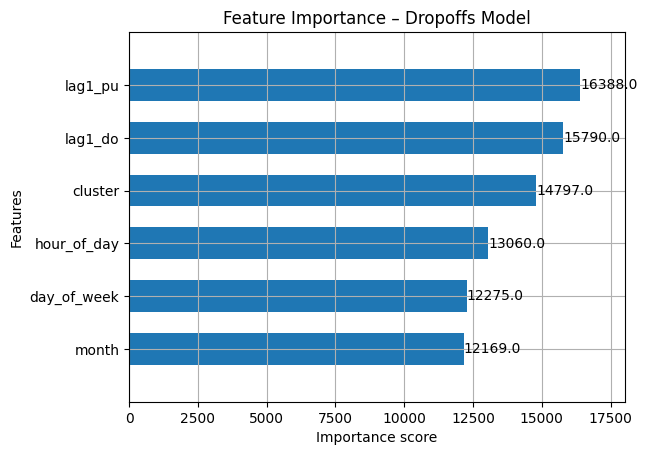

In [59]:
import xgboost as xgb
xgb.plot_importance(xgb_pu, height=0.6)
plt.title("Feature Importance – Pickups Model")
plt.show()

xgb.plot_importance(xgb_do, height=0.6)
plt.title("Feature Importance – Dropoffs Model")
plt.show()

# 24-Hour Ahead Forecasting

In [68]:
feature_cols = ["cluster", "hour_of_day", "day_of_week", "month", 
                "lag1_pu", "lag1_do"]
def forecast_next_24h(cluster_id, last_day_df, xgb_pu, xgb_do):
    """
    last_day_df: last day of available data (Nov 30 for validation, Dec 31 for test)
    xgb_pu: trained XGBoost pickups model
    xgb_do: trained XGBoost dropoffs model
    """
    
    # Extract last known values
    last_row = last_day_df[last_day_df["cluster"] == cluster_id].sort_values("hour").iloc[-1]

    lag_pu = last_row["pickups"]
    lag_do = last_row["dropoffs"]
    
    # Start from the next day at 00:00
    next_day_start = last_row["hour"].replace(hour=0) + pd.Timedelta(days=1)

    forecasts = []
    
    for h in range(24):
        current_hour = next_day_start + pd.Timedelta(hours=h)
        
        # Build feature row
        X = pd.DataFrame({
            "cluster": [cluster_id],
            "hour_of_day": [current_hour.hour],
            "day_of_week": [current_hour.dayofweek],
            "month": [current_hour.month],
            "lag1_pu": [lag_pu],
            "lag1_do": [lag_do]
        })

        # Predict pickups and dropoffs
        pred_pu = xgb_pu.predict(X)[0]
        pred_do = xgb_do.predict(X)[0]

        # Save prediction
        forecasts.append({
            "cluster": cluster_id,
            "forecast_hour": current_hour,
            "pred_pickups": pred_pu,
            "pred_dropoffs": pred_do
        })

        # Update lags for next hour
        lag_pu = pred_pu
        lag_do = pred_do
    
    return pd.DataFrame(forecasts)

In [70]:
clusters = sorted(train["cluster"].unique())

# last day available in validation set (Nov 30)
last_day = val[val["hour"].dt.date == val["hour"].dt.date.max()]

all_forecasts = []

for cid in clusters:
    df_fc = forecast_next_24h(
        cluster_id=cid,
        last_day_df=last_day,
        xgb_pu=xgb_pu,
        xgb_do=xgb_do
    )
    all_forecasts.append(df_fc)

final_forecasts = pd.concat(all_forecasts, ignore_index=True)
final_forecasts.head(30)

cluster       forecast_hour  pred_pickups  pred_dropoffs
0       0.0 2018-12-01 00:00:00      7.497045      12.000096
1       0.0 2018-12-01 01:00:00      5.118987       8.002867
2       0.0 2018-12-01 02:00:00      3.564168       4.826347
3       0.0 2018-12-01 03:00:00      2.298054       1.967552
4       0.0 2018-12-01 04:00:00      1.504893       1.044650
5       0.0 2018-12-01 05:00:00      1.704720      -0.777865
6       0.0 2018-12-01 06:00:00      3.171910       1.414138
7       0.0 2018-12-01 07:00:00      3.384823       1.394230
8       0.0 2018-12-01 08:00:00      1.536946       1.200068
9       0.0 2018-12-01 09:00:00      5.024077       2.638494
10      0.0 2018-12-01 10:00:00     10.077396       5.734397
11      0.0 2018-12-01 11:00:00     17.048754      11.068147
12      0.0 2018-12-01 12:00:00     23.783985      16.130005
13      0.0 2018-12-01 13:00:00     24.153456      21.561310
14      0.0 2018-12-01 14:00:00     26.671629      23.905355
15      0.0 2018-12-01 15:00:00     27.524094      26.223328
16      0.0 2018-12-01 16:00:00     26.899586      24.627451
17      0.0 2018-12-01 17:00:00     27.607853      29.471664
18      0.0 2018-12-01 18:00:00     24.410154      31.001844
19      0.0 2018-12-01 19:00:00     19.304541      25.881859
20      0.0 2018-12-01 20:00:00     17.126514      18.118383
21      0.0 2018-12-01 21:00:00     14.529147      18.369864
22      0.0 2018-12-01 22:00:00     12.685229      17.487425
23      0.0 2018-12-01 23:00:00     12.398119      16.451746
24      1.0 2018-12-01 00:00:00     54.435104      61.073189
25      1.0 2018-12-01 01:00:00     36.337132      32.735779
26      1.0 2018-12-01 02:00:00     23.177525      20.411562
27      1.0 2018-12-01 03:00:00     14.756256      13.479390
28      1.0 2018-12-01 04:00:00     13.495643      11.315417
29      1.0 2018-12-01 05:00:00     20.278093      15.443662

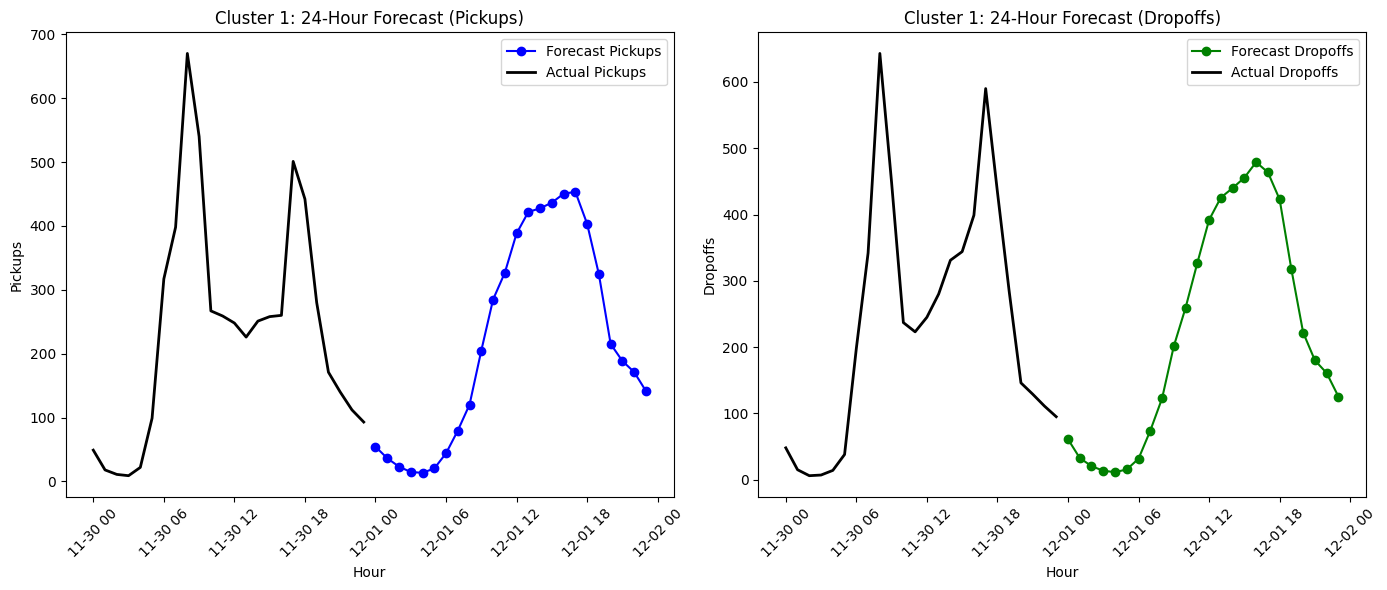

In [74]:
def plot_24h_forecast(cluster_id, forecast_df, actual_df=None):
    """
    forecast_df: output of your 24-hour forecasting function
    actual_df: actual pickups/dropoffs for that day (optional)
    """

    df_fc = forecast_df[forecast_df["cluster"] == cluster_id].copy()

    plt.figure(figsize=(14,6))

    # --- Pickups ---
    plt.subplot(1,2,1)
    plt.plot(df_fc["forecast_hour"], df_fc["pred_pickups"],
             label="Forecast Pickups", color='blue', marker='o')

    if actual_df is not None:
        df_actual = actual_df[actual_df["cluster"] == cluster_id]
        plt.plot(df_actual["hour"], df_actual["pickups"],
                 label="Actual Pickups", color='black', linewidth=2)

    plt.title(f"Cluster {cluster_id}: 24-Hour Forecast (Pickups)")
    plt.xlabel("Hour")
    plt.ylabel("Pickups")
    plt.xticks(rotation=45)
    plt.legend()

    # --- Dropoffs ---
    plt.subplot(1,2,2)
    plt.plot(df_fc["forecast_hour"], df_fc["pred_dropoffs"],
             label="Forecast Dropoffs", color='green', marker='o')

    if actual_df is not None:
        plt.plot(df_actual["hour"], df_actual["dropoffs"],
                 label="Actual Dropoffs", color='black', linewidth=2)

    plt.title(f"Cluster {cluster_id}: 24-Hour Forecast (Dropoffs)")
    plt.xlabel("Hour")
    plt.ylabel("Dropoffs")
    plt.xticks(rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_24h_forecast(cluster_id=1, 
                  forecast_df=final_forecasts,
                  actual_df=val[val["hour"].dt.date == val["hour"].dt.date.max()])